# Read in the data and get into a usable format

## Load in packages:

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.stats import linregress, theilslopes
import re

## Read in the data

These data were created using the GNSS_SWOT_data_processor.ipynb. The processor takes linear GNSS points and a SWOT PIXC point cloud data product and turns them into a single dataframe/csv. Each point contains the GNSS distance downstream, GNSS WSE, GNSS lat, GNSS lon, SWOT WSE, SWOT lat, SWOT lon, and all the quality indicators that are inherent with the SWOT data product. The code cell below runs will turn all the sections used in this analysis into a pandas dictionary. 

In [2]:
base_directory = 'data/SWOT_GNSS_processed_csvs/'
# Dictionary to store the dataframes
dataframes_dict = {}
# Walk through all directories and files
for root, dirs, files in os.walk(base_directory):
    for filename in files:
        if filename.endswith("_height.csv"):
            # Construct full file path
            file_path = os.path.join(root, filename)
            # Read the CSV file into a DataFrame
            df = pd.read_csv(file_path)
            # Store the DataFrame in the dictionary with the file name (without extension) as the key
            key = os.path.splitext(filename)[0]
            dataframes_dict[key] = df

The code below will set the color schemes and keys that will be used throught this analysis. At the end there is a plot that shows just the GNSS data as a function of distance vs WSE.

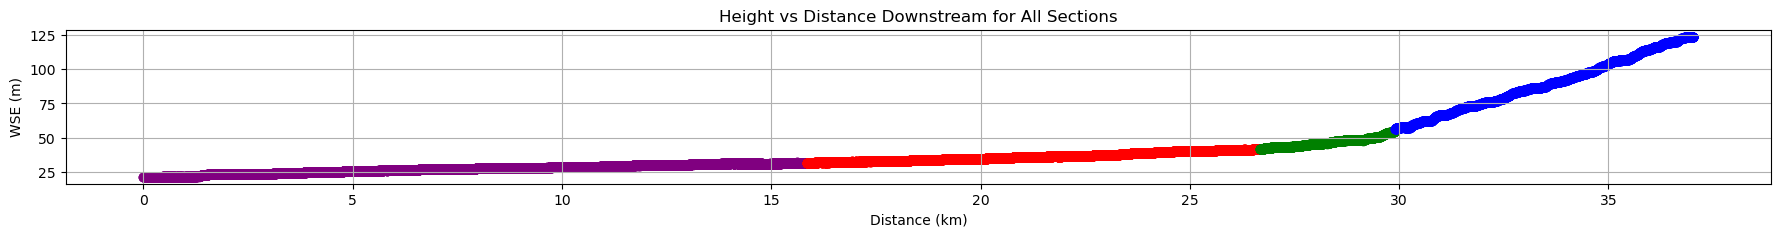

In [3]:
# Define the reversed order of keys
keys_order = [
    'buffered_66190600011_GNSS_SWOT_cumulative_dist_height',
    'buffered_66190600023_GNSS_SWOT_cumulative_dist_height',
    'buffered_66190600033_GNSS_SWOT_cumulative_dist_height',
    'buffered_66190600041_GNSS_SWOT_cumulative_dist_height',
    'buffered_66190600041_20240131_GNSS_SWOT_cumulative_dist_height',
    'buffered_66190600023_20240131_GNSS_SWOT_cumulative_dist_height'
]

# Define the color scheme for each key
color_scheme = {
    'buffered_66190600011_GNSS_SWOT_cumulative_dist_height': 'purple',
    'buffered_66190600023_GNSS_SWOT_cumulative_dist_height': 'red',
    'buffered_66190600033_GNSS_SWOT_cumulative_dist_height': 'green',
    'buffered_66190600041_GNSS_SWOT_cumulative_dist_height': 'blue',
    'buffered_66190600041_20240131_GNSS_SWOT_cumulative_dist_height' : 'darkblue',
    'buffered_66190600023_20240131_GNSS_SWOT_cumulative_dist_height' : 'darkred'
}


color_scheme_SWOT = {
    'buffered_66190600011_GNSS_SWOT_cumulative_dist_height': 'violet',
    'buffered_66190600023_GNSS_SWOT_cumulative_dist_height': 'lightsalmon',
    'buffered_66190600033_GNSS_SWOT_cumulative_dist_height': 'limegreen',
    'buffered_66190600041_GNSS_SWOT_cumulative_dist_height': 'xkcd:sky blue',
    'buffered_66190600041_20240131_GNSS_SWOT_cumulative_dist_height' : 'cornflowerblue',
    'buffered_66190600023_20240131_GNSS_SWOT_cumulative_dist_height' : 'lightsalmon'
}

key_labels = {
    'buffered_66190600011_GNSS_SWOT_cumulative_dist_height': '66190600011 ',
    'buffered_66190600023_GNSS_SWOT_cumulative_dist_height':  '66190600023 ',
    'buffered_66190600033_GNSS_SWOT_cumulative_dist_height':  '66190600033 ',
    'buffered_66190600041_GNSS_SWOT_cumulative_dist_height':  '66190600041 ',
    'buffered_66190600041_20240131_GNSS_SWOT_cumulative_dist_height' : '66190600041*',
    'buffered_66190600023_20240131_GNSS_SWOT_cumulative_dist_height' : '66190600023*'
}

# Initialize the cumulative offset
cumulative_offset = 0

# Plotting
plt.figure(figsize=(22, 2))

for key in keys_order[0:4]:
    df = dataframes_dict[key]
    
    # Handle NaNs by dropping them
    df = df.dropna(subset=['cumulative_distance', 'Height(m)'])
    
    # Adjust the cumulative distance for the current section
    cumulative_distance_gnss = (df['cumulative_distance']/1000) + cumulative_offset

    cumulative_distance_swot = (df['cumulative_distance']/1000) + cumulative_offset
    
    # Scatter plot for cumulative_distance_GNSS vs GNSS_height
    plt.scatter(cumulative_distance_gnss, df['Height(m)'], label=f'GNSS ({key})', marker='o', color=color_scheme[key])

    # Scatter plot for cumulative_distance_SWORD vs nearest_height_SWORD
    #plt.scatter(cumulative_distance_swot, df['nearest_height_SWORD'], label=f'SWOT', alpha = .2, marker='x', color = color_scheme_SWOT[key])
    
    
    # Update the cumulative offset for the next section
    cumulative_offset = (df['cumulative_distance']/1000 + cumulative_offset).max()

# Adding titles and labels
plt.title('Height vs Distance Downstream for All Sections')
plt.xlabel('Distance (km)')
plt.ylabel('WSE (m)')
#plt.legend()
plt.grid(True)

plt.savefig(f'figs/GNSS_data_all_reaches.png', dpi=300, bbox_inches='tight')

# Show plot
plt.show()

## Classification filter

The filter below is what filters the SWOT data to remove points classified as land, land near water, and dark water. This filter will be used on ALL SWOT data in this lab. At no point will any plot or analysis contain the points listed above.

In [4]:
def apply_filter(df):
    return df[(df['classification'] > 2) & (df['classification'] !=5)].copy()

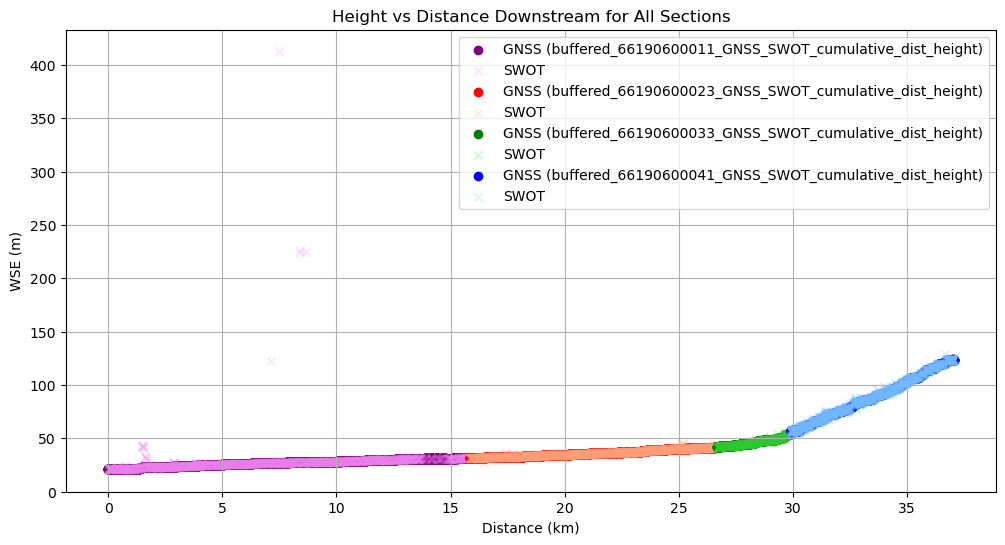

In [5]:
# Initialize the cumulative offset
cumulative_offset = 0

# Plotting
plt.figure(figsize=(12, 6))

for key in keys_order[0:4]:
    df = dataframes_dict[key]

    # Apply filter to keep points where classification is greater than 2
    df_filtered = apply_filter(df)
    
    # Handle NaNs by dropping them
    df = df.dropna(subset=['cumulative_distance', 'Height(m)'])
    
    # Adjust the cumulative distance for the current section
    cumulative_distance_gnss = (df['cumulative_distance']/1000) + cumulative_offset
    

    cumulative_distance_swot = (df_filtered['nearest_GNSS_dist']/1000) + cumulative_offset
    
    # Scatter plot for cumulative_distance_GNSS vs GNSS_height
    plt.scatter(cumulative_distance_gnss, df['Height(m)'], label=f'GNSS ({key})', marker='o', color=color_scheme[key])

    
    # Scatter plot for cumulative_distance_SWORD vs nearest_height_SWORD
    plt.scatter(cumulative_distance_swot, df_filtered['height'], label=f'SWOT', alpha = .2, marker='x', color = color_scheme_SWOT[key])
    
    
    # Update the cumulative offset for the next section
    cumulative_offset = (df['cumulative_distance']/1000 + cumulative_offset).max()

# Adding titles and labels
plt.title('Height vs Distance Downstream for All Sections')
plt.xlabel('Distance (km)')
plt.ylabel('WSE (m)')
plt.legend()
plt.grid(True)

#plt.savefig(f'figs/GNSS_data_all_reaches.png', dpi=300, bbox_inches='tight')

# Show plot
plt.show()

The plot above shows all GNSS vs SWOT on the days where the SWOT overpass and GNSS data were collected on the same day. There is apparently overall a good agreement. NExt we will plot all the four days above individually as well as two more hand selected days that have an offset from the GNSS by about 2-3 weeks and were specifically chosen because they have higher noise and outliers. They will be the final two plots below

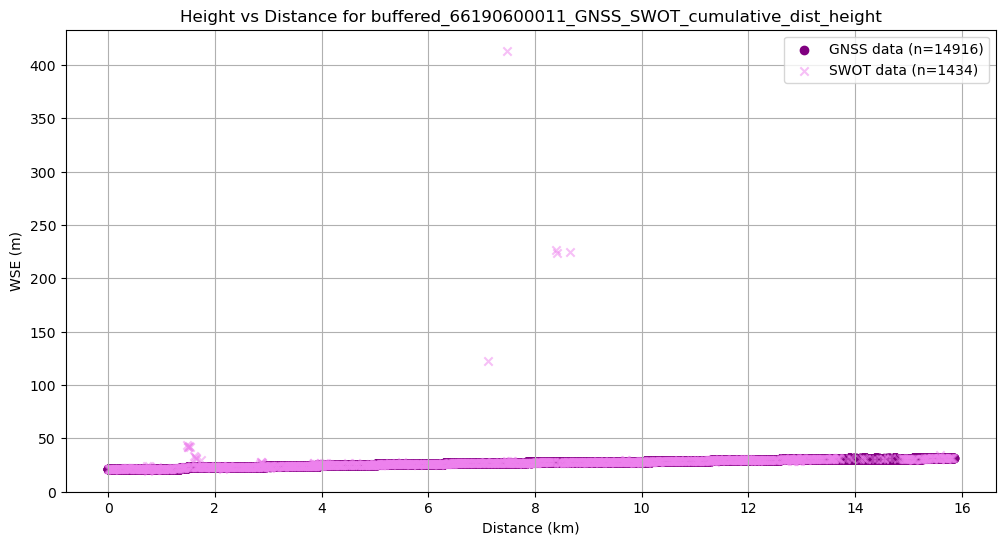

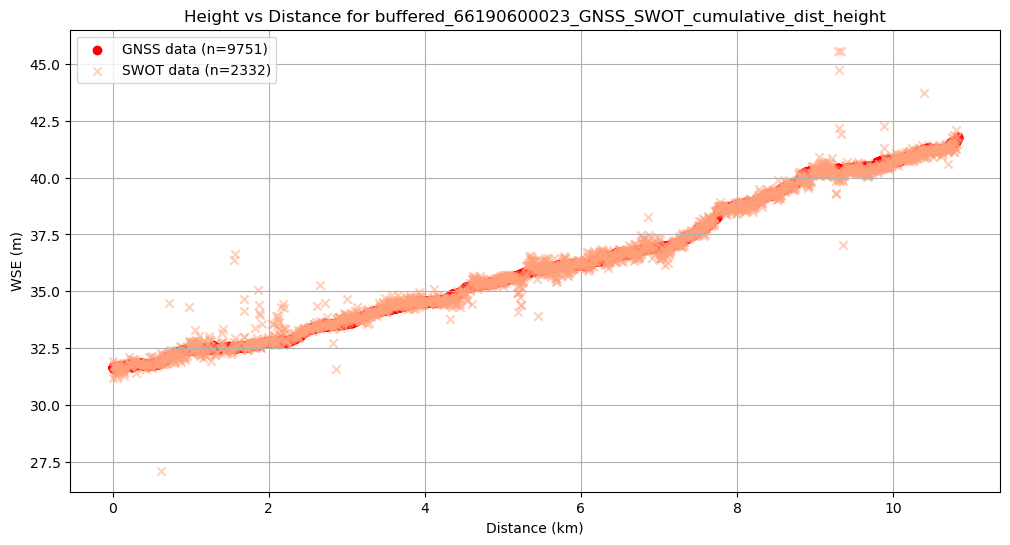

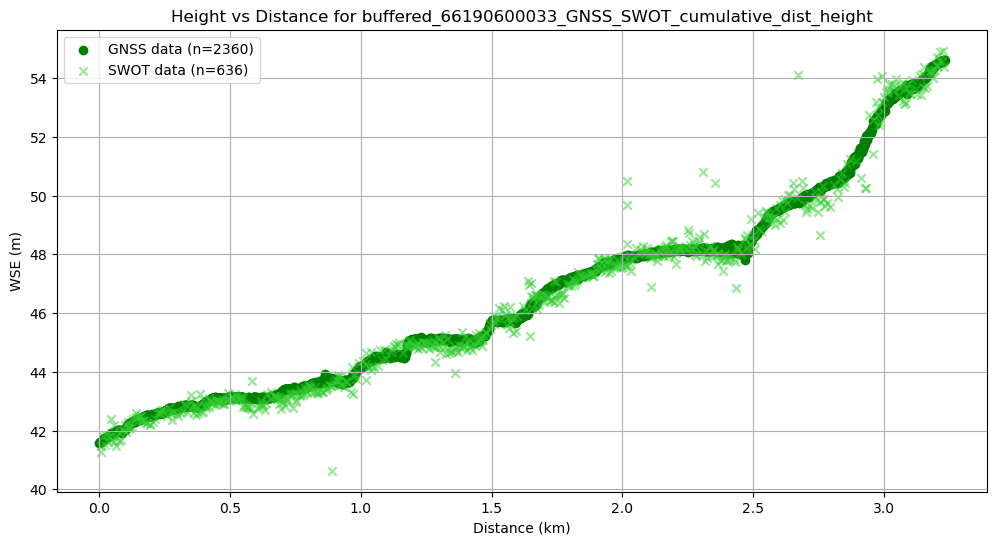

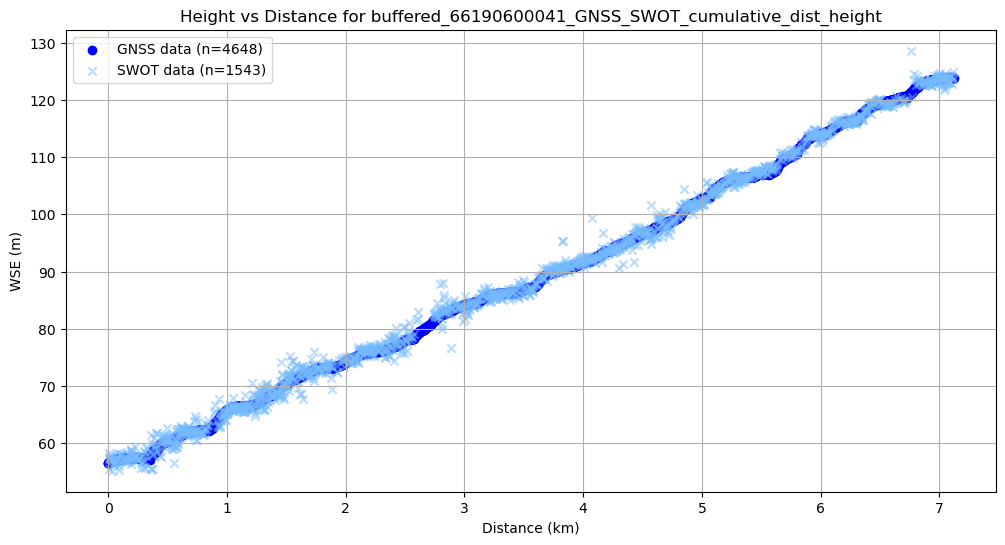

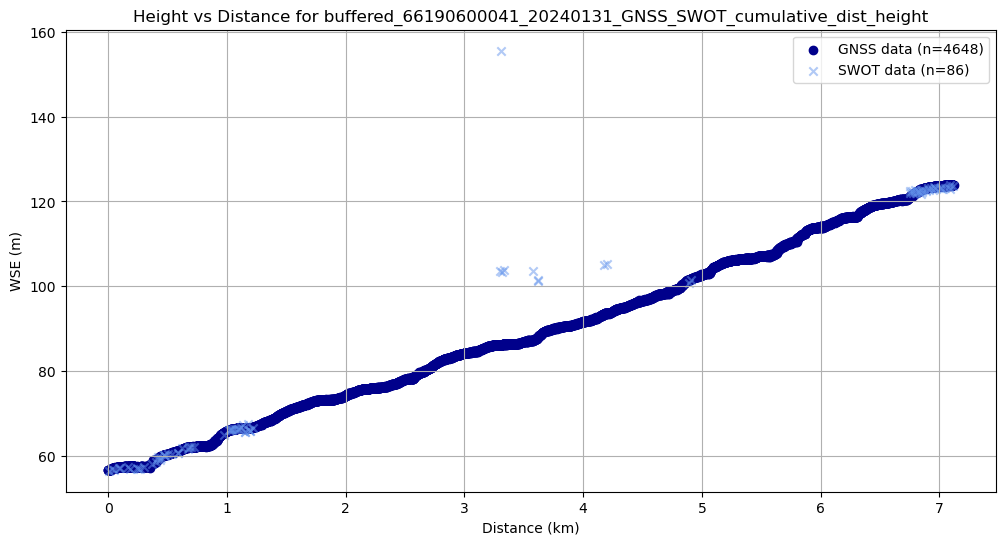

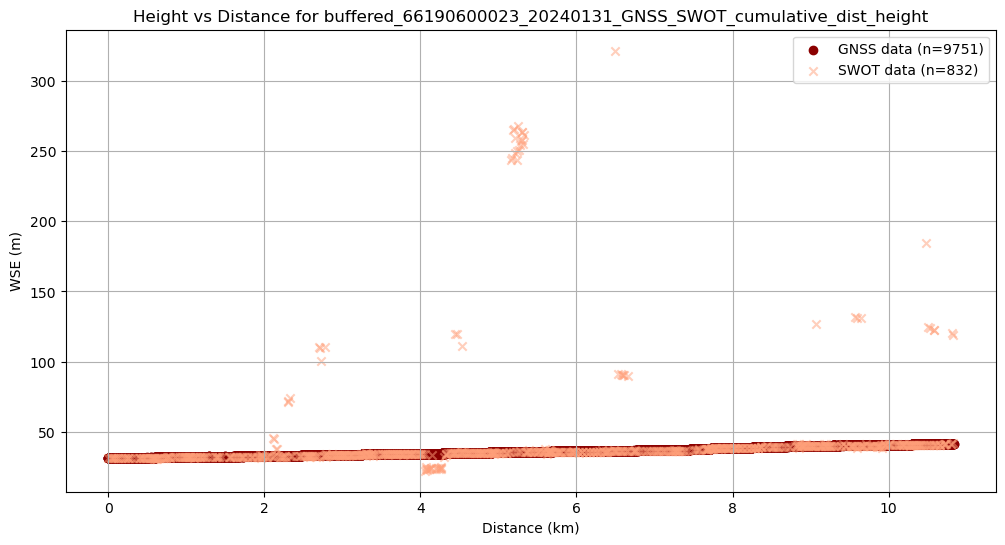

In [6]:
# Loop through each key in the dictionary
for key in keys_order:
    df = dataframes_dict[key].iloc[::-1]  # Reverse the order of the dataframe
    
    # Apply filter to keep points where classification is greater than 2
    df_filtered = apply_filter(df)
    
    # Plotting
    plt.figure(figsize=(12, 6))
    
    non_na_gnss = len(df)

    non_na_SWOT = len(df_filtered['height'].dropna())
    
    # Scatter plot for cumulative_distance_GNSS vs GNSS_height
    plt.scatter(df['cumulative_distance'] / 1000, df['Height(m)'], label=f'GNSS data (n={non_na_gnss})', marker='o', color=color_scheme[key])
    
    # Scatter plot for cumulative_distance_SWORD vs nearest_height_SWORD
    plt.scatter(df_filtered['nearest_GNSS_dist'] / 1000, df_filtered['height'], label=f'SWOT data (n={non_na_SWOT})', alpha = .5, marker='x', color = color_scheme_SWOT[key])
    
    # Adding titles and labels
    plt.title(f'Height vs Distance for {key}')
    plt.xlabel('Distance (km)')
    plt.ylabel('WSE (m)')
    plt.legend()
    plt.grid(True)

    plt.savefig(f'figs/{key}_SWOT_vs_GNSS.png', dpi=300, bbox_inches='tight')
    
    # Show plot
    plt.show()


Notice how the last two have much more extreme outliers?

# 1:1 comparison

In this section we will be going over the 1:1 comparison for the SWOT vs GNSS data. To do this we need to have the same number of points for the GNSS and SWOT. To do this we are going to bin for every 50m of distance and take the median height. We can then set the GNSS agains the SWOT plotting the GNSS WSE as the x, the SWOT WSE as the y, and take some summary statistics such as slope of line of best fit, SD of residuals, and $R^2$ value.

## Binning

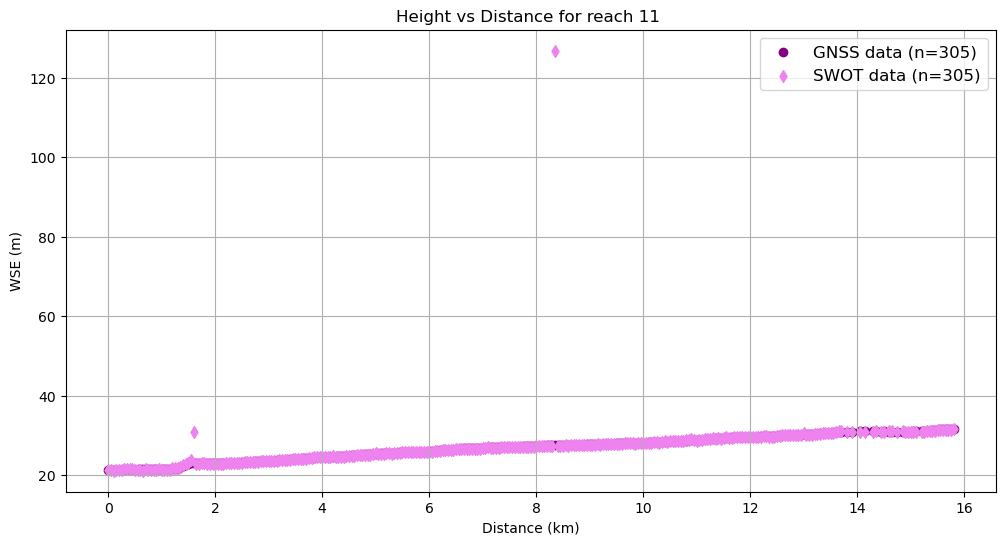

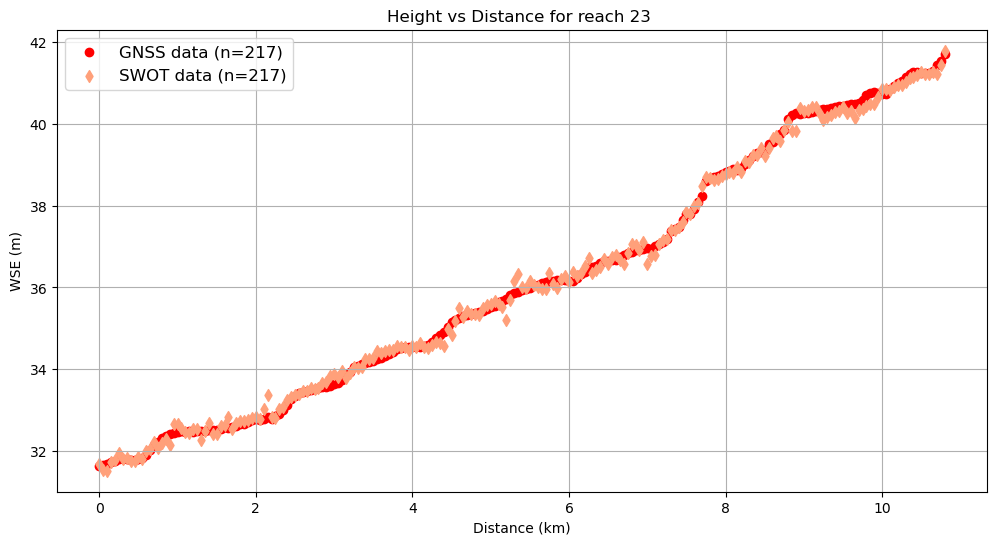

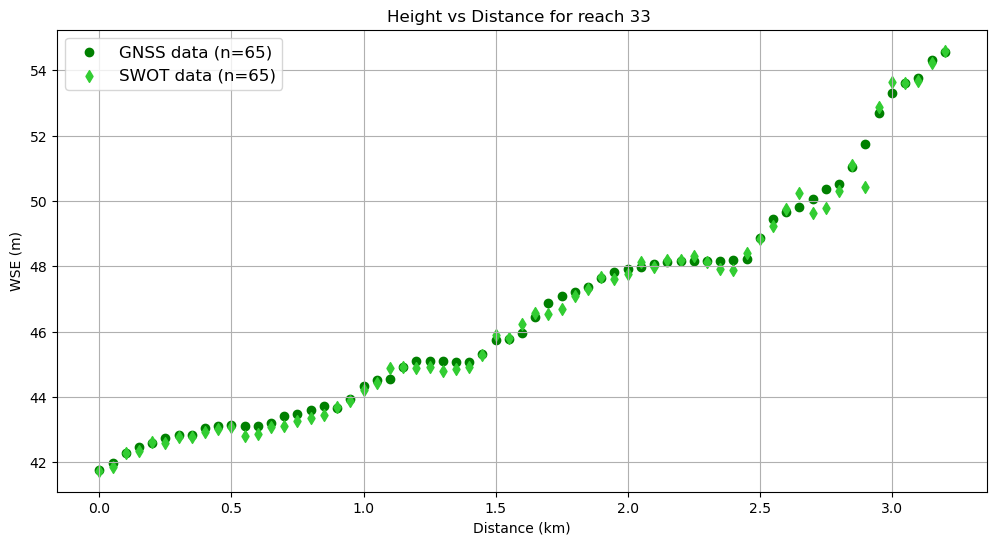

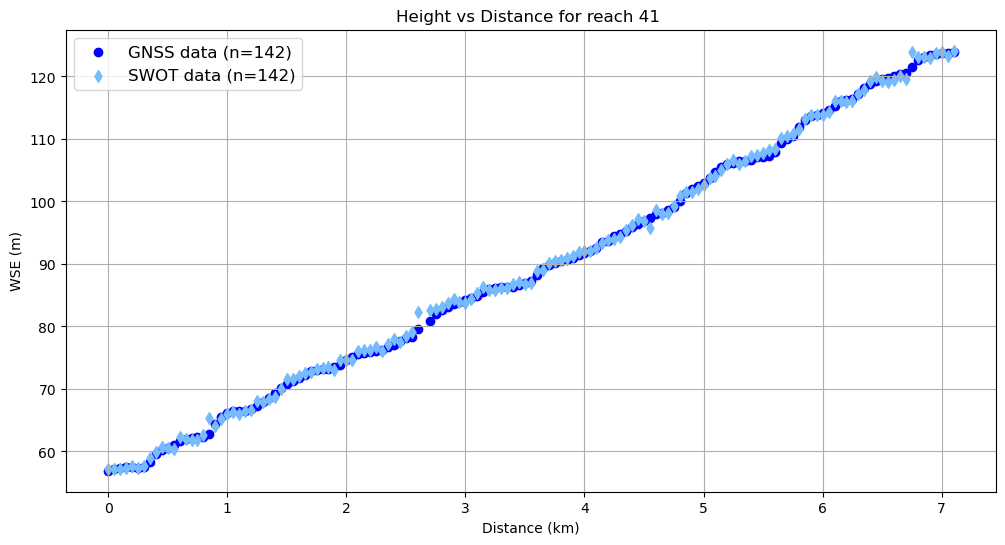

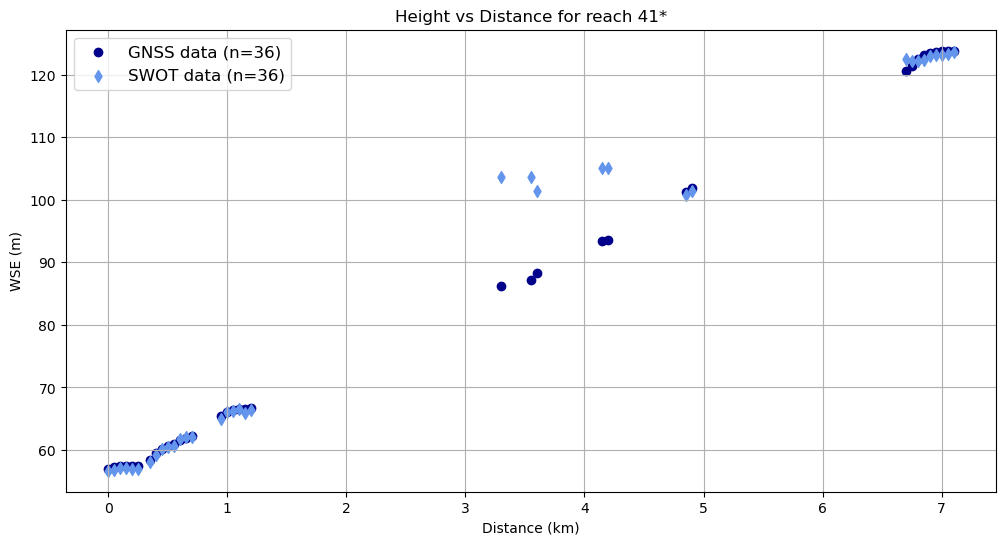

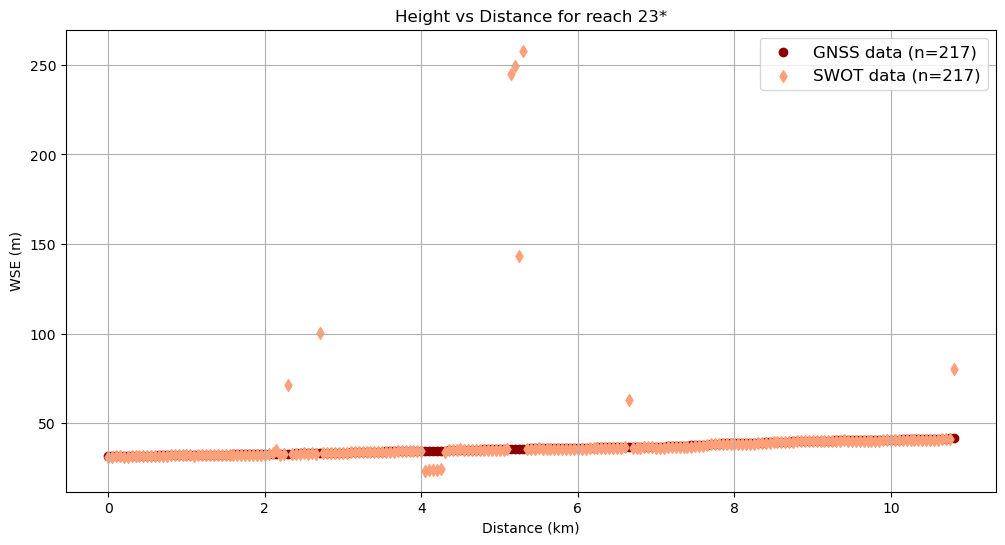

In [7]:
# Loop through each key in the dictionary
for key in keys_order:
    df = dataframes_dict[key].iloc[::-1].copy()  # Reverse the order of the dataframe
    
    # Apply filter to keep points where classification is greater than 2
    df_filtered = apply_filter(df)
    
    # Create bins for every 5 meters in GNSS cumulative_distance
    bins_gnss = np.arange(0, df['cumulative_distance'].max() + 50, 50)
    bins_swot = np.arange(0, df_filtered['cumulative_distance'].max() + 50, 50)
    
    # Bin and average GNSS data
    df['binned_distance_GNSS'] = pd.cut(df['cumulative_distance'], bins=bins_gnss)
    #df['bin'] = df['binned_distance_GNSS'].apply(lambda interval: interval.left)
    df_binned_gnss = df.groupby('binned_distance_GNSS', as_index=False, observed=True).agg({'cumulative_distance': 'median', 'Height(m)': 'median'}).dropna()
    df_binned_gnss['bin'] = df_binned_gnss['binned_distance_GNSS'].apply(lambda interval: float(interval.left))
    df_binned_gnss['bin'] = df_binned_gnss['bin'].astype(float)
    
    # Bin and average SWOT data based on GNSS disntance downstream
    df_filtered['binned_distance_GNSS'] = pd.cut(df_filtered['cumulative_distance'], bins=bins_swot)
    df_binned_swot = df_filtered.groupby('binned_distance_GNSS', observed=True, as_index=False).agg({'cumulative_distance': 'median', 'height': 'median'}).dropna()
    df_binned_swot['bin'] = df_binned_swot['binned_distance_GNSS'].apply(lambda interval: float(interval.left))
    df_binned_swot['bin'] = df_binned_swot['bin'].astype(float)


    # Extract unique bin values from each DataFrame
    bins_swot = set(df_binned_swot['bin'])
    bins_gnss = set(df_binned_gnss['bin'])

    # Compute the intersection of the two sets
    common_bins = bins_swot.intersection(bins_gnss)

    # Filter both DataFrames to include only the common bins
    df_binned_swot_filtered = df_binned_swot[df_binned_swot['bin'].isin(common_bins)]
    df_binned_gnss_filtered = df_binned_gnss[df_binned_gnss['bin'].isin(common_bins)]
    
    # Plotting
    plt.figure(figsize=(12, 6))
    
    non_na_gnss = len(df_binned_gnss_filtered)
    non_na_SWOT = len(df_binned_swot_filtered)

    # Scatter plot for binned GNSS data
    plt.scatter(df_binned_gnss_filtered['bin'] / 1000, df_binned_gnss_filtered['Height(m)'], 
                label=f'GNSS data (n={non_na_gnss})', marker='o', color=color_scheme[key])

    # Scatter plot for binned SWOT data
    plt.scatter(df_binned_swot_filtered['bin'] / 1000, df_binned_swot_filtered['height'], 
                label=f'SWOT data (n={non_na_SWOT})', alpha=1, marker='d', color=color_scheme_SWOT[key])

    # Adding titles and labels
    # Extract numerical value from key between underscores
    key_numeric = re.search(r'_(\d+)_', str(key))
    key_label = key_numeric.group(1) if key_numeric else 'Unknown'
    
    # Scatter plot for cumulative_distance_GNSS vs GNSS_height
    plt.title(f'Height vs Distance for reach {key_labels[key][-3:]}')
    plt.xlabel('Distance (km)')
    plt.ylabel('WSE (m)')
    plt.legend(fontsize=12)
    plt.grid(True)

    # Define a filename based on the key
    filename = f"publication_figs_2/aggregated_profile_{key_labels[key][-3:]}.jpg"

    # Save the figure as a high-resolution .jpg
    plt.savefig(filename, dpi=300, bbox_inches='tight', format='jpg')
    
    # Show plot
    plt.show()


## The 1:1 comparison

Now that we know the binning works, we will apply the 1:1 comparison below:

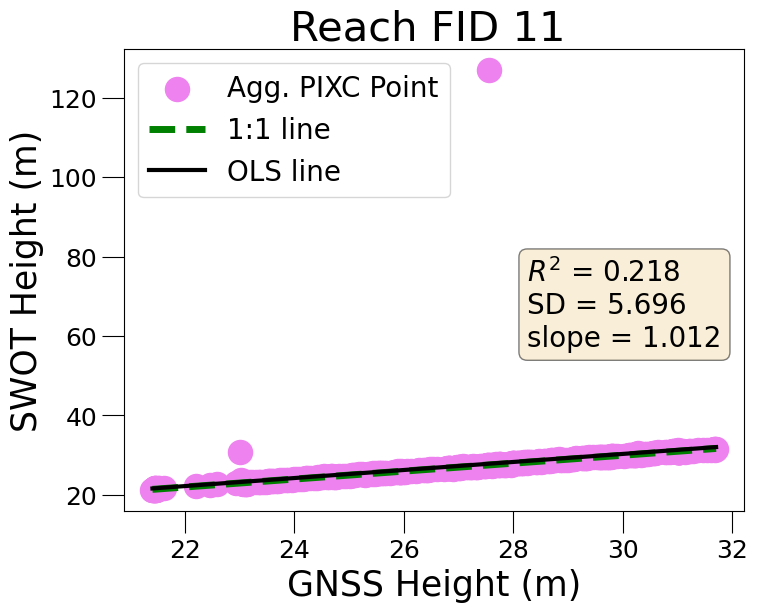

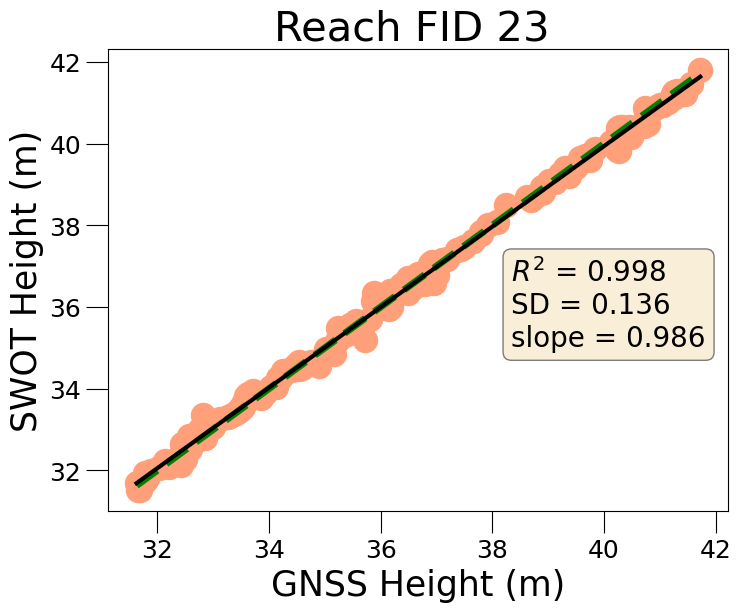

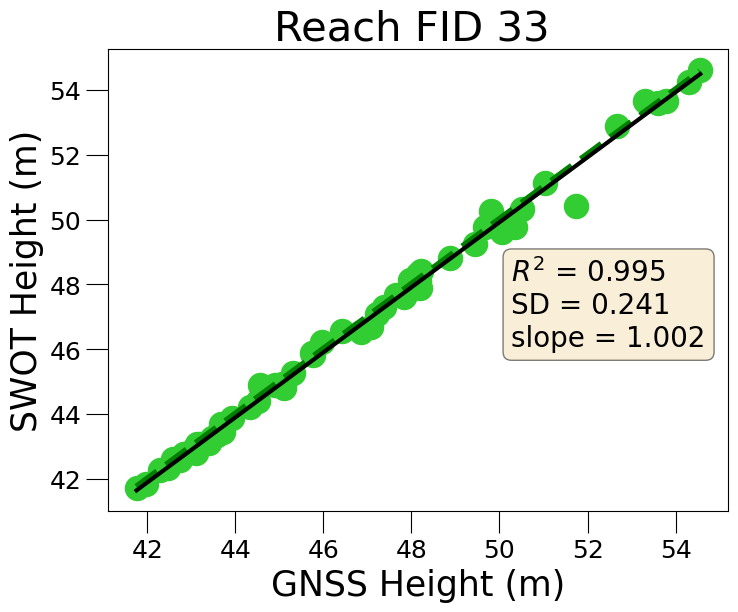

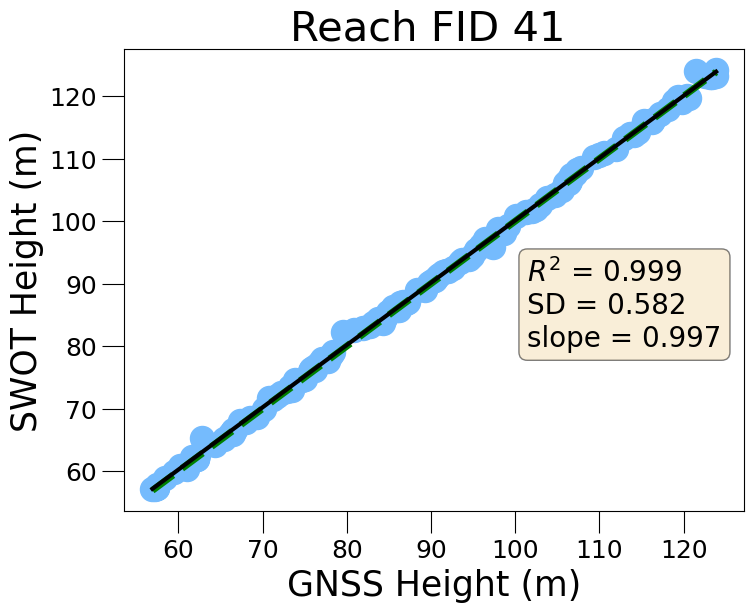

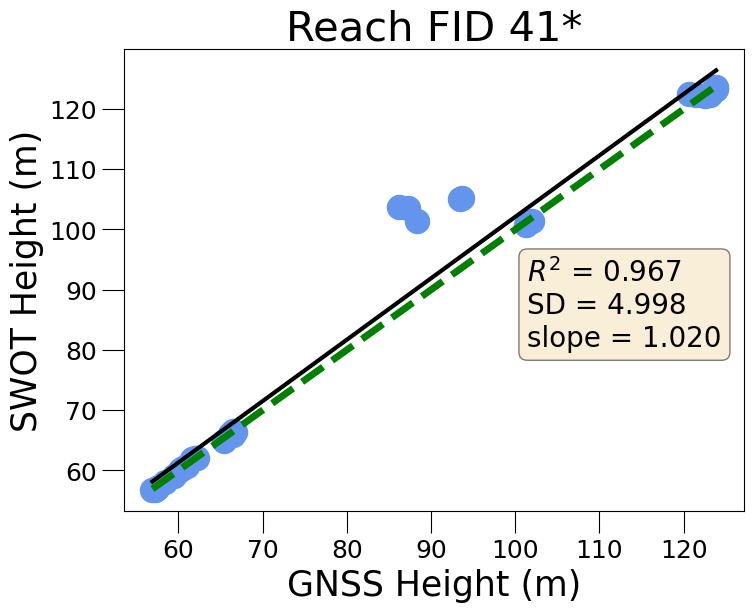

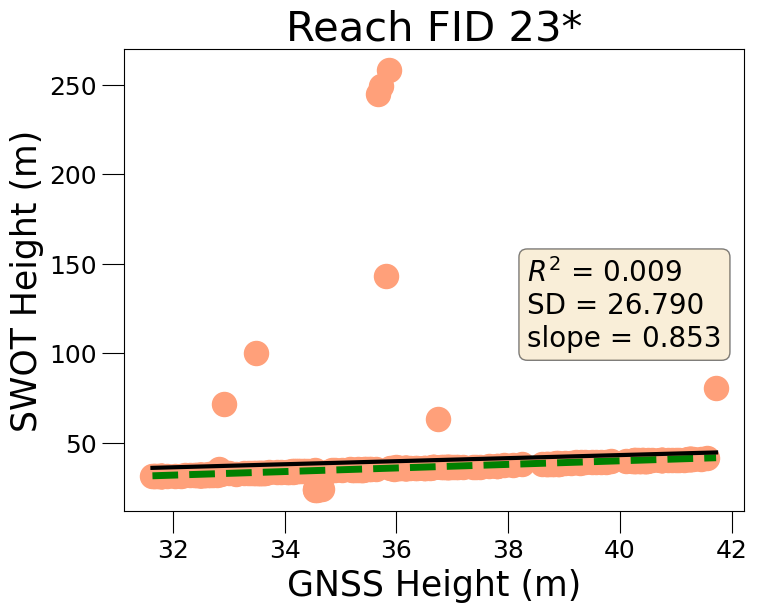

In [8]:
# Loop through each key in the dictionary
for i, key in enumerate(keys_order):
    df = dataframes_dict[key].iloc[::-1].copy()  # Reverse the order of the dataframe
    
    # Apply filter to keep points where classification is greater than 2
    df_filtered = apply_filter(df)
    
    # Create bins for every 5 meters in GNSS cumulative_distance
    bins_gnss = np.arange(0, df['cumulative_distance'].max() + 50, 50)
    bins_swot = np.arange(0, df_filtered['cumulative_distance'].max() + 50, 50)
    
    # Bin and average GNSS data
    df['binned_distance_GNSS'] = pd.cut(df['cumulative_distance'], bins=bins_gnss)
    df_binned_gnss = df.groupby('binned_distance_GNSS', as_index=False, observed=True).agg({
        'cumulative_distance': 'median',
        'Height(m)': 'median'
    }).dropna()
    df_binned_gnss['bin'] = df_binned_gnss['binned_distance_GNSS'].apply(lambda interval: float(interval.left))
    df_binned_gnss['bin'] = df_binned_gnss['bin'].astype(float)
    
    # Bin and average SWOT data based on GNSS distance downstream
    df_filtered['binned_distance_GNSS'] = pd.cut(df_filtered['cumulative_distance'], bins=bins_swot)
    df_binned_swot = df_filtered.groupby('binned_distance_GNSS', observed=True, as_index=False).agg({
        'cumulative_distance': 'median',
        'height': 'median'
    }).dropna()
    df_binned_swot['bin'] = df_binned_swot['binned_distance_GNSS'].apply(lambda interval: float(interval.left))
    df_binned_swot['bin'] = df_binned_swot['bin'].astype(float)
    
    # Extract unique bin values from each DataFrame
    bins_swot_set = set(df_binned_swot['bin'])
    bins_gnss_set = set(df_binned_gnss['bin'])
    
    # Compute the intersection of the two sets
    common_bins = bins_swot_set.intersection(bins_gnss_set)
    
    # Filter both DataFrames to include only the common bins
    df_binned_swot_filtered = df_binned_swot[df_binned_swot['bin'].isin(common_bins)]
    df_binned_gnss_filtered = df_binned_gnss[df_binned_gnss['bin'].isin(common_bins)]
    
    # 1. Merge the two DataFrames on 'bin'
    merged_df = pd.merge(df_binned_gnss_filtered, df_binned_swot_filtered, on='bin', suffixes=('_gnss', '_swot'))
    
    # Assuming these are your height columns:
    x = merged_df['Height(m)']   # GNSS heights (x-axis)
    y = merged_df['height']        # SWOT heights (y-axis)
    
    # 2. Compute the best-fit line and statistics
    
    # Calculate the linear regression parameters (slope and intercept)
    slope, intercept = np.polyfit(x, y, 1)
    # Generate points along the best-fit line for plotting
    line_x = np.linspace(x.min(), x.max(), 100)
    line_y = slope * line_x + intercept
    y_at_xmin = slope * x.min() + intercept
    y_bias = y_at_xmin - x.min()

    
    # Calculate R² (coefficient of determination)
    correlation_matrix = np.corrcoef(x, y)
    correlation_xy = correlation_matrix[0, 1]
    r_squared = correlation_xy ** 2
    
    # Calculate the standard deviation (SD) of the residuals
    predicted_y = slope * x + intercept
    residuals = y - predicted_y
    sd = np.std(residuals)
    
    # 3. Plot the data
    
    plt.figure(figsize=(8, 6))
    
    # Scatter plot for the data points
    plt.scatter(x, y, marker='o', color=color_scheme_SWOT[key], label = 'Agg. PIXC Point', s = 300)
    
    # Add the 1:1 line (slope 1 through the origin)
    # Adjust the range for the identity line to cover the data
    min_val = min(x.min(), x.min())
    max_val = max(x.max(), x.max())
    identity_line = np.linspace(min_val, max_val, 100)
    plt.plot(identity_line, identity_line, color='green', linewidth = 5, linestyle='--', label='1:1 line')

     # Plot the line of best fit
    plt.plot(line_x, line_y, color='black', linewidth = 3, label=f'OLS line')
    
    
    # Labeling the axes and the title
    plt.xlabel('GNSS Height (m)', fontsize=25)
    plt.ylabel('SWOT Height (m)', fontsize=25)

    
    # Annotate the plot with R², SD, and slope values.
    plt.text(0.65, 0.55, f'$R^2$ = {r_squared:.3f}\nSD = {sd:.3f}\nslope = {slope:.3f}',
             transform=plt.gca().transAxes,
             verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5), fontsize = 20)
    
    if i == 0:  # Only add legend on the first plot
        plt.legend(fontsize=20)

    # Adding titles and labels
    # Extract numerical value from key between underscores
    key_numeric = re.search(r'_(\d+)_', str(key))
    key_label = key_numeric.group(1) if key_numeric else 'Unknown'
    
    # Scatter plot for cumulative_distance_GNSS vs GNSS_height
    plt.title(f'Reach FID {key_labels[key][-3:]}', fontsize = 30)
    plt.tick_params(axis='both', which='major', labelsize=18, size=16)

    # Define a filename based on the key
    filename = f"publication_figs_2/1:1_{key_labels[key][-3:]}.jpg"

    # Save the figure as a high-resolution .jpg
    plt.savefig(filename, dpi=300, bbox_inches='tight', format='jpg')

       # Show the plot
    plt.show()
    # plt.xlabel('Distance (km)')
    # plt.ylabel('WSE (m)')
    # plt.legend(fontsize=12)
    # plt.grid(True)

    # # Save plot
    # plt.savefig(f'figs/{key}_SWOT_vs_GNSS_binned.png', dpi=300, bbox_inches='tight')

    # # Show plot
    # plt.show()


# OLS comparison between GNSS and SWOT WSE

## Calculate the OLS slopes

We will do this for GNSS WSE and SWOT PICX WSE for all 6 datasets

In [9]:
slope_differences_ols = []

# List to store the regression results
ols_results = []

# Loop through each key in the dictionary
for key in keys_order:
    df = dataframes_dict[key].iloc[::-1].copy()  # Reverse the order of the dataframe

    # Apply filter to keep points where classification is greater than 2
    df_filtered = apply_filter(df)
    
    # Create bins for every 5 meters in GNSS cumulative_distance
    bins_gnss = np.arange(0, df['cumulative_distance'].max() + 2, 2)
    bins_swot = np.arange(0, df_filtered['nearest_GNSS_dist'].max() + 50, 50)
    
    # Bin and average GNSS data
    df['binned_distance_GNSS'] = pd.cut(df['cumulative_distance'], bins=bins_gnss)
    df_binned_gnss = df.groupby('binned_distance_GNSS', observed=True).agg({'cumulative_distance': 'median', 'Height(m)': 'median'}).dropna()

    # Bin and average SWOT data
    df_filtered.loc[:, 'binned_distance_SWOT'] = pd.cut(df_filtered['nearest_GNSS_dist'], bins=bins_swot)
    df_binned_swot = df_filtered.groupby('binned_distance_SWOT', observed=True).agg({'nearest_GNSS_dist': 'median', 'height': 'median'}).dropna()

    
     # Prepare GNSS data for OLS
    X1_GNSS = df_binned_gnss['cumulative_distance'].dropna()
    y1_GNSS = df_binned_gnss['Height(m)'].dropna()

    # Fit OLS model using scipy's linregress for GNSS data
    slope_gnss, intercept_gnss, r_value_gnss, p_value_gnss, std_err_gnss = linregress(X1_GNSS, y1_GNSS)

    # Append GNSS OLS results to the list, with params as a pandas Series
    ols_results.append({
        'key': key,
        'model': 'GNSS',
        'params': pd.Series({'const': intercept_gnss, 'slope': slope_gnss}),
        'r_squared': r_value_gnss ** 2
    })

    gnss_slope_ols = slope_gnss

    # Prepare SWORD data for OLS
    X2_SWOT = df_binned_swot['nearest_GNSS_dist'].dropna()
    y2_SWOT = df_binned_swot['height'].dropna()

    # Fit OLS model using scipy's linregress for SWORD data
    slope_sword, intercept_sword, r_value_sword, p_value_sword, std_err_sword = linregress(X2_SWOT, y2_SWOT)

    # Append SWORD OLS results to the list, with params as a pandas Series
    ols_results.append({
        'key': key,
        'model': 'SWORD',
        'params': pd.Series({'const': intercept_sword, 'slope': slope_sword}),
        'r_squared': r_value_sword ** 2
    })

    sword_slope_ols = slope_sword

    # Calculate the difference in slopes for OLS
    gnss_slope_ols = gnss_slope_ols * 1000
    sword_slope_ols = sword_slope_ols * 1000

    slope_difference_ols = gnss_slope_ols - sword_slope_ols
    slope_differences_ols.append({
        'key': key,
        'gnss_slope': gnss_slope_ols,
        'sword_slope': sword_slope_ols,
        'slope_diff': slope_difference_ols
    })
    
    print(f'{key} is done')

buffered_66190600011_GNSS_SWOT_cumulative_dist_height is done
buffered_66190600023_GNSS_SWOT_cumulative_dist_height is done
buffered_66190600033_GNSS_SWOT_cumulative_dist_height is done
buffered_66190600041_GNSS_SWOT_cumulative_dist_height is done
buffered_66190600041_20240131_GNSS_SWOT_cumulative_dist_height is done
buffered_66190600023_20240131_GNSS_SWOT_cumulative_dist_height is done


## Plot slope differences

Here we will plot the slope differences between GNSS and SWOT PIXC WSE for all 6 datasets

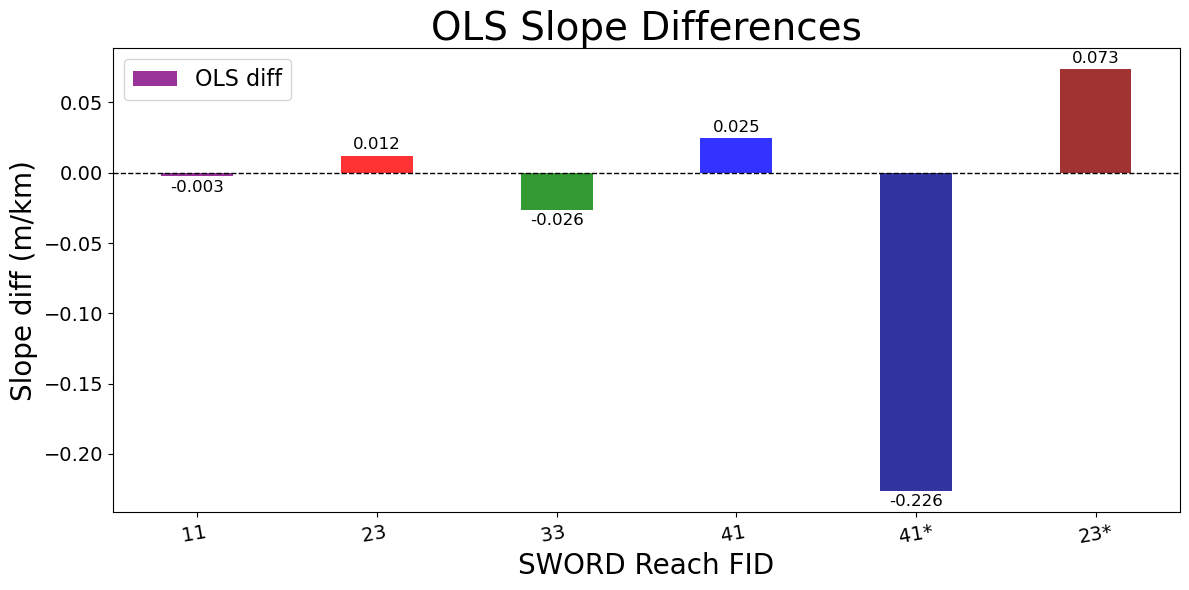

In [10]:
ols_slopes = [item['slope_diff'] for item in slope_differences_ols]

indices = np.arange(len(keys_order))  # Create one position for each key
bar_width = 0.4

fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.bar(
    indices, 
    ols_slopes, 
    bar_width, 
    label='OLS diff', 
    color=[color_scheme[key] for key in keys_order],
    alpha=0.8
)

# Draw a horizontal line at y=0
ax.axhline(0, color='black', linewidth=1, linestyle='--')

# Annotate each bar with its value
for bar, slope in zip(bars, ols_slopes):
    height = bar.get_height()
    va = 'bottom' if height >= 0 else 'top'
    offset = 0.01 * max(abs(np.array(ols_slopes)))
    offset = offset if height >= 0 else -offset
    ax.text(bar.get_x() + bar.get_width() / 2, height + offset, 
            f'{slope:.3f}', ha='center', va=va, fontsize=12, color='black')

# Set title and axis labels
ax.set_title('OLS Slope Differences', fontsize=28)
ax.set_xlabel('SWORD Reach FID', fontsize=20)
ax.set_ylabel('Slope diff (m/km)', fontsize=20)

# Use key_labels for the x-ticks
ax.set_xticks(indices)
ax.set_xticklabels([key_labels[key][-3:] for key in keys_order], fontsize=14, rotation=10)

ax.tick_params(axis='y', labelsize=14)
ax.legend(fontsize=16)
plt.tight_layout()
plt.show()


# Stable Slope Filter

## Quantile slopes

Now that we have a baseline statistical understanding of the distribution of each dataset, lets test the stable slope filter based on linear quantile regression.

The code cell below will perform 100 quantile regressions on each of the 6 datasets, performing a regression every 0.01 quantiles. This will result in 600 regressions. The results will be stored in:

    quantile_regression_results

In [11]:
def perform_quantile_regressions(keys_order, dataframes_dict):
    # Initialize a dictionary to store the slopes and intercepts
    quantile_regression_results = {}

    for key in keys_order:
        df = dataframes_dict[key].iloc[::-1]  # Reverse the order of the dataframe

        # Apply filter to keep points where classification is greater than 2
        df_filtered = apply_filter(df)
        
        # Process GNSS data
        df_GNSS_data = pd.DataFrame({
            'y': df['Height(m)'], 
            'x': df['cumulative_distance'] / 1000
        }).dropna()

        # Quantiles from 0.05 to 0.95
        quantiles = np.arange(0.01, 1, 0.01)

        # Store results for GNSS
        gnss_slopes = []
        gnss_results = []
        for q in quantiles:
            quant_reg = smf.quantreg('y ~ x', df_GNSS_data).fit(q=q, max_iter=10000)
            gnss_results.append((quant_reg.params['Intercept'], quant_reg.params['x']))
            gnss_slopes.append(quant_reg.params['x'])

        # Process SWORD data
        df_SWOT_data = pd.DataFrame({
            'y': df_filtered['height'], 
            'x': df_filtered['nearest_GNSS_dist'] / 1000
        }).dropna()

        # Store results for SWORD
        sword_results = []
        sword_slopes = []
        for q in quantiles:
            quant_reg = smf.quantreg('y ~ x', df_SWOT_data).fit(q=q, max_iter=10000)
            sword_results.append((quant_reg.params['Intercept'], quant_reg.params['x']))
            sword_slopes.append(quant_reg.params['x'])

        diff_slopes = [point1 - point2 for point1, point2 in zip(gnss_slopes, sword_slopes)]

        # Save the slopes and intercepts in the dictionary
        quantile_regression_results[key] = {
            'quantiles': quantiles,
            'gnss_results': gnss_results,
            'sword_results': sword_results,
            'diff_slopes': diff_slopes
        }

    return quantile_regression_results

# Perform quantile regressions and store the results
quantile_regression_results = perform_quantile_regressions(keys_order, dataframes_dict)

## Plotting Quantile vs Slope

Cool, now using the results from above, we are going to plot each slope for each of the 6 datasets. Each plot will contain a line to show how GNSS slope of WSE changes across quantiles, and the same for SWOT.

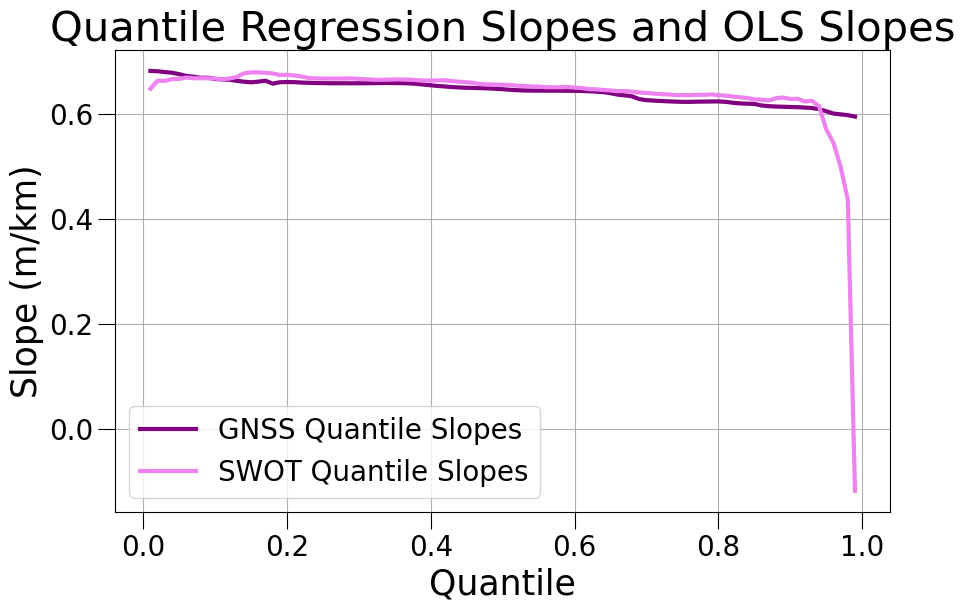

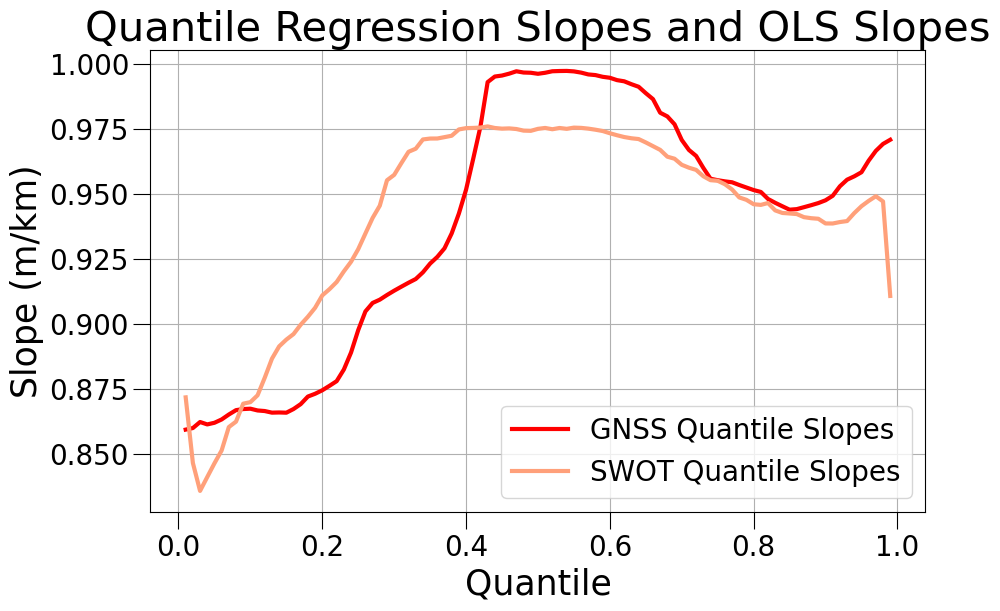

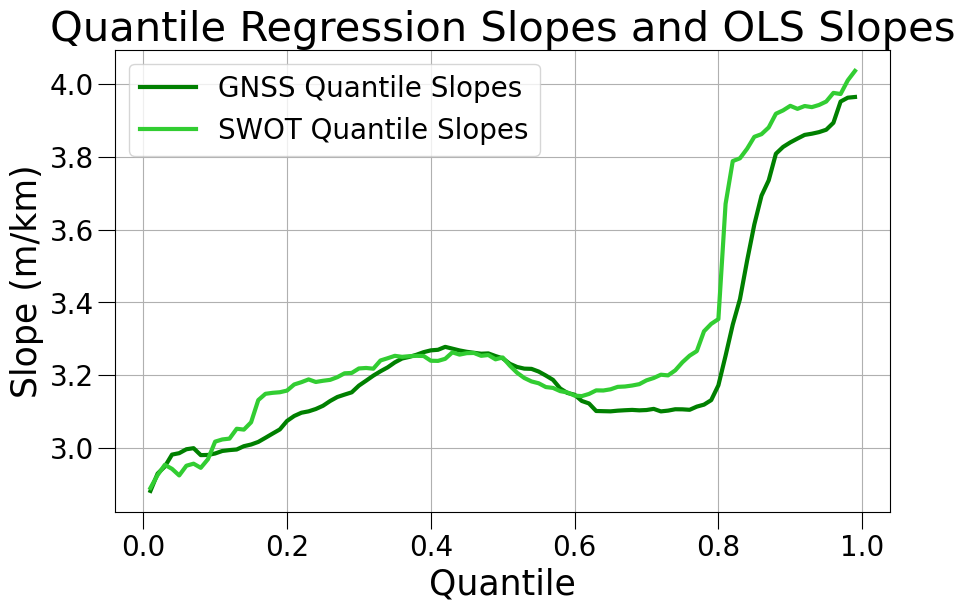

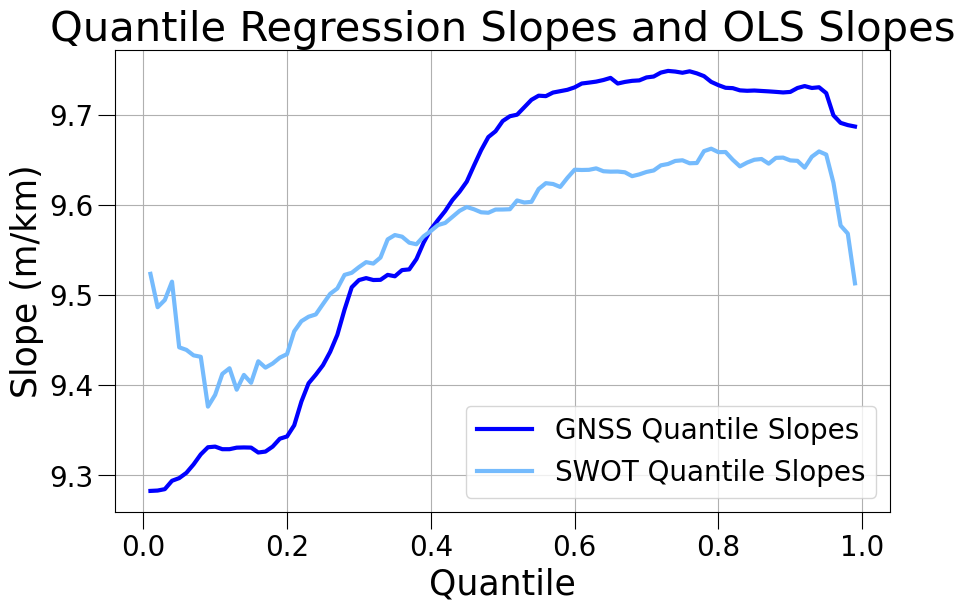

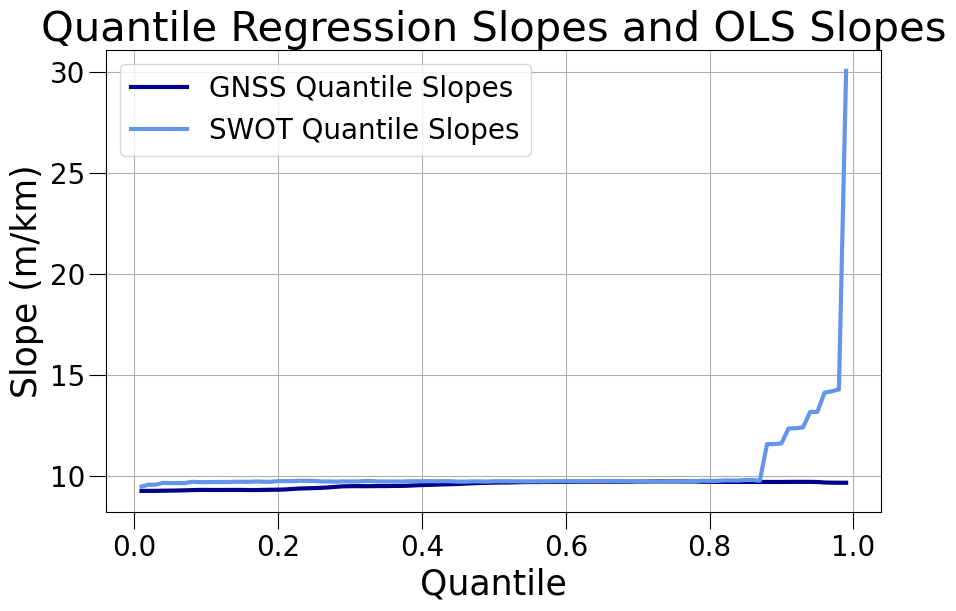

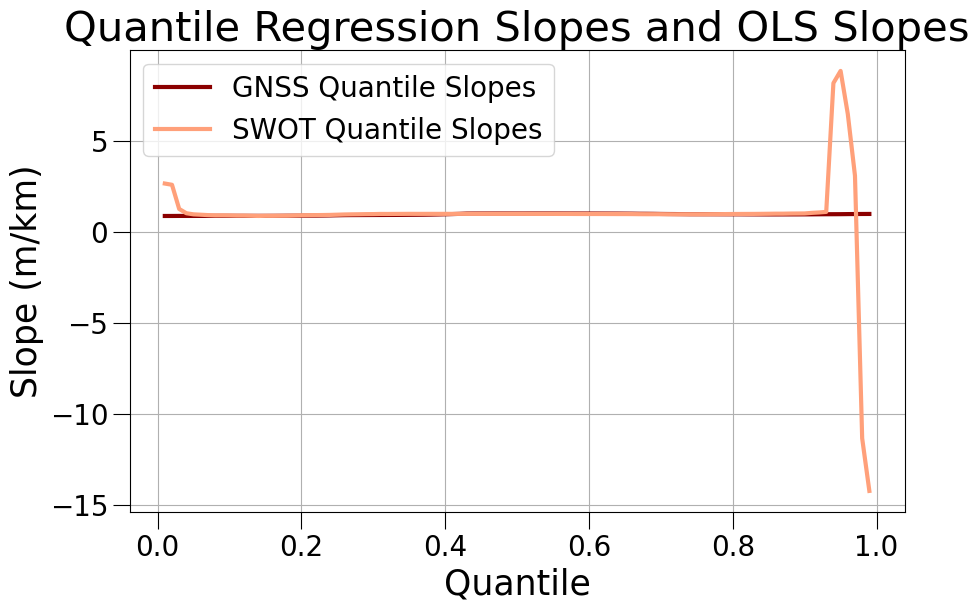

In [12]:
def plot_quantile_regression_results(quantile_regression_results, keys_order, color_scheme, color_scheme_SWOT):
    for key in keys_order:
        # Retrieve quantile regression results
        quantiles = quantile_regression_results[key]['quantiles']
        gnss_results = quantile_regression_results[key]['gnss_results']
        sword_results = quantile_regression_results[key]['sword_results']

        # Extract slopes for plotting
        gnss_slopes = [result[1] for result in gnss_results]
        sword_slopes = [result[1] for result in sword_results]

        # Plotting the results
        plt.figure(figsize=(10, 6))
        plt.plot(quantiles, gnss_slopes, linestyle='-', label=f'GNSS Quantile Slopes', linewidth=3, color=color_scheme[key])
        plt.plot(quantiles, sword_slopes, linestyle='-', label=f'SWOT Quantile Slopes', linewidth=3, color=color_scheme_SWOT[key])
            
        plt.title(f'Quantile Regression Slopes and OLS Slopes', fontsize=30)
        plt.xlabel('Quantile', fontsize=25)
        plt.ylabel('Slope (m/km)', fontsize=25)
        plt.tick_params(axis='both', which='major', labelsize=20, size=12)
        plt.legend(fontsize=20)
        plt.grid(True)
        
        plt.savefig(f'figs/{key}_SWOT_vs_GNSS_quantile_with_OLS_and_TheilSen.png', dpi=300, bbox_inches='tight')
        
        plt.show()

# Plot the quantile regression results
plot_quantile_regression_results(quantile_regression_results, keys_order, color_scheme, color_scheme_SWOT)

Cool, now we can see how each dataset's slope changes based on the quantile we are looking at. It appears that for the most part the GNSS and SWOT data have the same trends across basically all quantiles except for the first plot, and the last 2. There are some more extreme deviations. What happens if we plot all the SWOT slopes by quantile on the same plot?

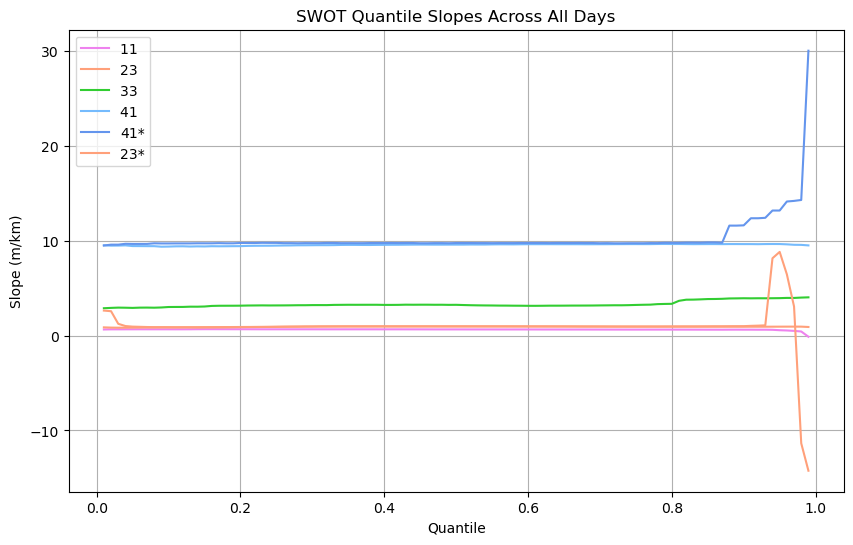

In [13]:
def plot_swot_slopes_vs_quantile(quantile_regression_results, keys_order, color_scheme_SWOT):
    plt.figure(figsize=(10, 6))

    for idx, key in enumerate(keys_order):
        # Retrieve quantile regression results
        quantiles = quantile_regression_results[key]['quantiles']
        sword_results = quantile_regression_results[key]['sword_results']

        # Extract slopes for plotting
        sword_slopes = [result[1] for result in sword_results]

        # Plotting the SWOT slopes for this key
        plt.plot(quantiles, sword_slopes, linestyle='-', color=color_scheme_SWOT[key], label=key_labels[key][-3:])
    
    plt.title(f'SWOT Quantile Slopes Across All Days')
    plt.xlabel('Quantile')
    plt.ylabel('Slope (m/km)')
    plt.legend()
    plt.grid(True)
    
    plt.savefig(f'figs/SWOT_quantile_slopes_all_keys.png', dpi=300, bbox_inches='tight')
    
    plt.show()

# Plot the SWOT quantile slopes for all keys on the same plot
plot_swot_slopes_vs_quantile(quantile_regression_results, keys_order[0:], color_scheme_SWOT)


The instability in the last two becomes much more apparent when we display the data like this! Note that the purple reach also seems to be unstable right near the last few quantiles as well. We will plot those with finer x tics so we can identify the stable slope range more easily by human observation.

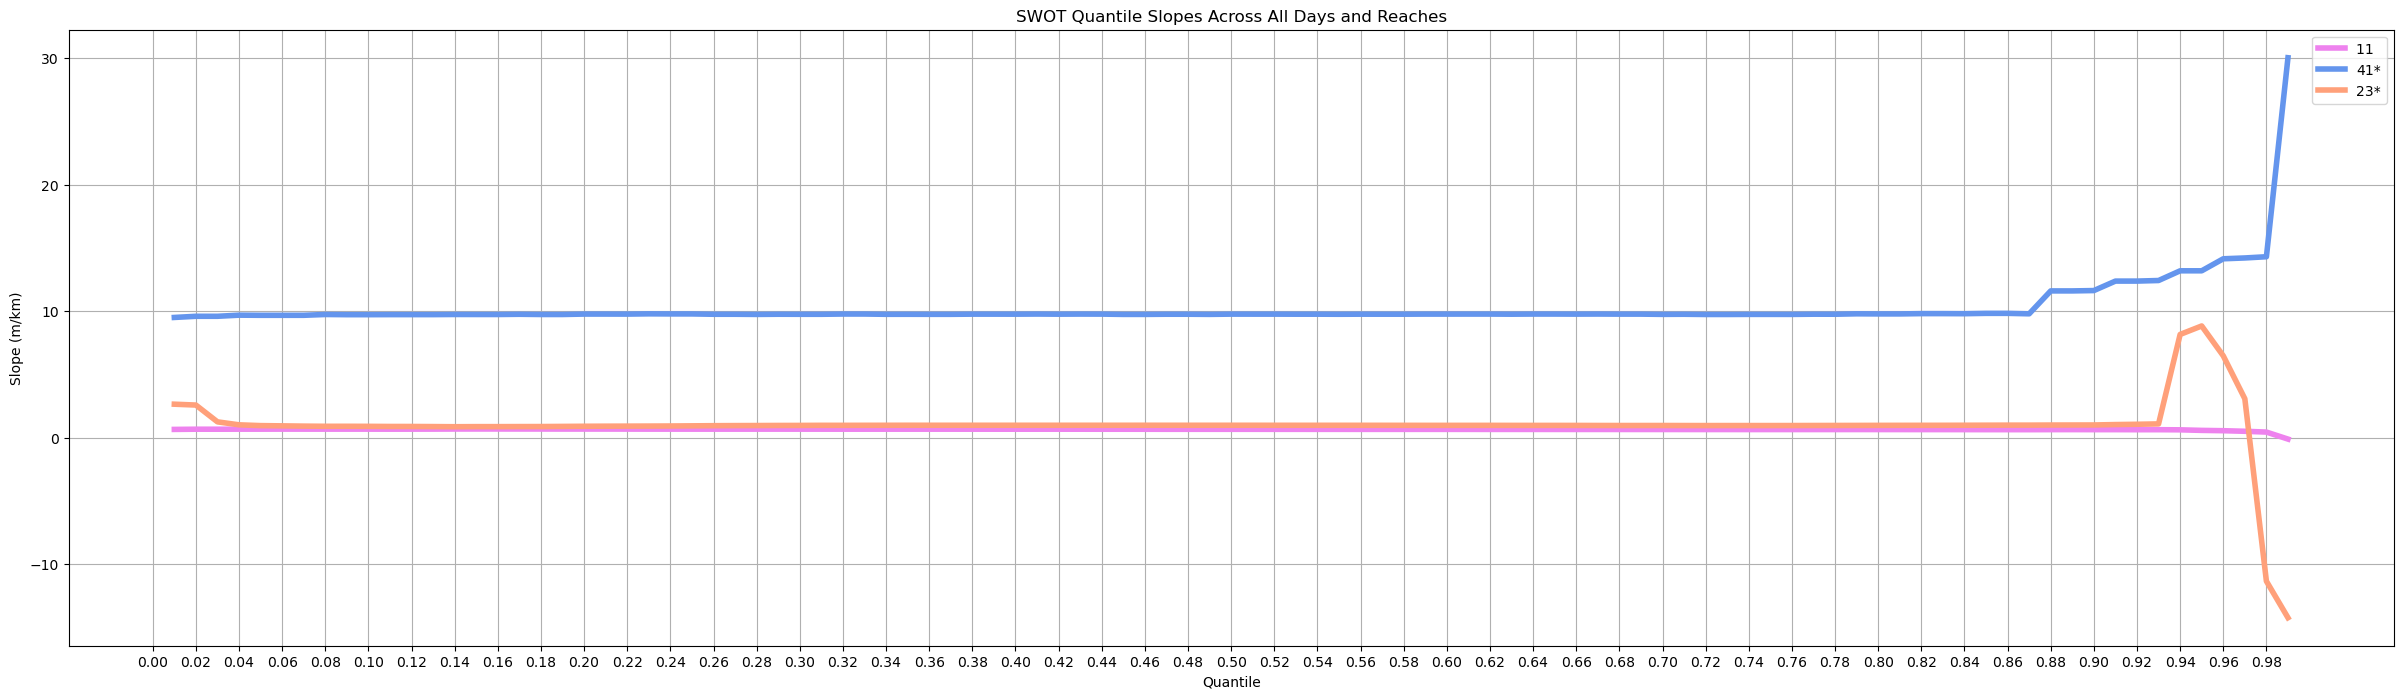

In [14]:
def plot_swot_slopes_vs_quantile(quantile_regression_results, keys_order, color_scheme_SWOT):
    plt.figure(figsize=(30, 8))

    for key in keys_order:
        # Retrieve quantile regression results
        quantiles = quantile_regression_results[key]['quantiles']
        sword_results = quantile_regression_results[key]['sword_results']

        # Extract slopes for plotting
        sword_slopes = [result[1] for result in sword_results]

        # Plotting the SWOT slopes for this key
        plt.plot(quantiles, sword_slopes, linestyle='-', color=color_scheme_SWOT[key], linewidth=4, label=key_labels[key][-3:])
    
    plt.title(f'SWOT Quantile Slopes Across All Days and Reaches')
    plt.xlabel('Quantile')
    plt.ylabel('Slope (m/km)')
    plt.legend()
    plt.grid(True)

    plt.xticks(np.arange(0, 1, 0.02))
    
    plt.savefig(f'figs/SWOT_quantile_slopes_all_keys.png', dpi=300, bbox_inches='tight')
    
    plt.show()

# Plot the SWOT quantile slopes for all keys on the same plot
plot_swot_slopes_vs_quantile(
    quantile_regression_results,
    [keys_order[0]] + keys_order[-2:],
    color_scheme_SWOT
)

## Identifing the Stable Slope Range

After zooming in on the plot the stable slope ranges have been identified as:

11: 0.00-0.98

41*: 0.00 - 0.87

23* 0.03 - 0.93

## Detrending the data

We will use those ranges to filter out the outliers that are causing the slopes to behave unexpectedly. But before we do this, we will need to detrend those 3 datasets. We know that OLS will work poorly to represent the slope of the data if there are high outliers, so to do this we will use the more robust median quantile slope or in other words, the quantile slope at 0.5 as the trend to detrend.


In [15]:
# Ensure the directory exists to save the CSV files
output_dir = 'data/quantile_filtered_csvs/'
os.makedirs(output_dir, exist_ok=True)

quantile_number = 50 #median quantile

# Lists to store the computed values for each dataset
gnss_ns = []
swot_ns = []
slopes = []


# Loop through each key in the dictionary
for key in keys_order[0:1] + keys_order[4:]:
    df = dataframes_dict[key].iloc[::-1].copy()  # Reverse the order and make a copy of the dataframe

    # Apply classification filter
    df_filtered = apply_filter(df)

    # Process GNSS data
    df_GNSS_data = pd.DataFrame({
        'y': df['Height(m)'], 
        'x': df['cumulative_distance']
    }).dropna()

    # Perform 0.5 quantile regression for GNSS
    gnss_model = smf.quantreg('y ~ x', df_GNSS_data)
    gnss_res = gnss_model.fit(q=0.5, max_iter=10000)
    gnss_slope = gnss_res.params['x']
    gnss_intercept = gnss_res.params['Intercept']

    df_SWOT_data = pd.DataFrame({
        'y': df_filtered['height'], 
        'x': df_filtered['nearest_GNSS_dist']
    }).dropna()

    # Perform 0.5 quantile regression for SWOT
    swot_model = smf.quantreg('y ~ x', df_SWOT_data)
    swot_res = swot_model.fit(q=0.5, max_iter=10000)
    swot_slope = swot_res.params['x']
    swot_intercept = swot_res.params['Intercept']

    # Detrend GNSS data using the 0.5 quantile slope
    df['Height_detrended'] = df['Height(m)'] - ((quantile_regression_results[key]['gnss_results'][quantile_number][1]/1000) * df['cumulative_distance'])

    # Detrend SWOT data
    df_filtered['height_detrended'] = df_filtered['height'] - ((quantile_regression_results[key]['sword_results'][quantile_number][1]/1000) * df_filtered['nearest_GNSS_dist'])

    # Combine the detrended datasets for OLS regression with dummy variables
    combined_df = pd.DataFrame({
        'Height_detrended': np.concatenate([df['Height_detrended'].values, df_filtered['height_detrended'].values]),
        'x': np.concatenate([np.zeros(len(df)), np.ones(len(df_filtered))])
    })

    # Store the calculated values
    gnss_ns.append(len(df['Height(m)']))
    swot_ns.append(len(df_filtered['height']))

    # Perform 0.5 quantile regression for the combined data
    both_model = smf.quantreg('Height_detrended ~ x', combined_df)
    both_res = both_model.fit(q=0.5, max_iter=10000)
    both_slope = both_res.params['x']
    both_intercept = both_res.params['Intercept']

    slopes.append(both_slope)

    # Save df and df_filtered as CSV files
    df.to_csv(f'{output_dir}/{key}_df.csv', index=False)
    df_filtered.to_csv(f'{output_dir}/{key}_df_filtered.csv', index=False)

## Applying the Stable Slope range

Now each dataset has been detrended and the results are stored in some new csvs. Don't ask me why I have chosen to do things this way, I just have. Now we will test to see if the filter works first lets plot the 23* reach again with no stable slope filter.

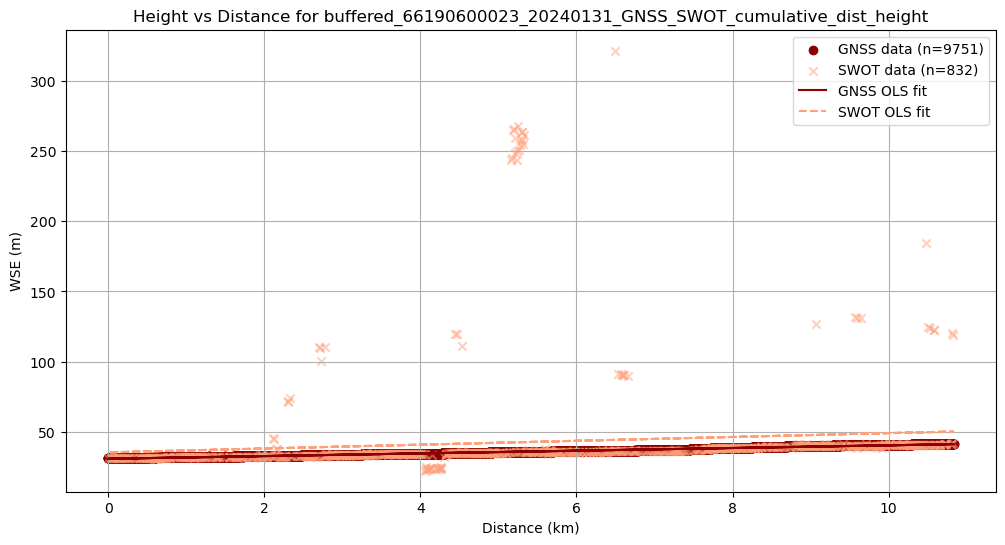

In [16]:
plt.figure(figsize=(12, 6))  # Adjust the figure size to accommodate all plots

# Loop through each key in the dictionary
for key in keys_order[5:]:
    # Load the saved CSV files
    df = pd.read_csv(f'{output_dir}/{key}_df.csv')
    df_filtered = pd.read_csv(f'{output_dir}/{key}_df_filtered.csv')

    #Apply the stable slope filter for 'height_detrended'
    lower_bound = df_filtered['height_detrended'].quantile(0.00)
    upper_bound = df_filtered['height_detrended'].quantile(1)

    # Filter the DataFrame to keep only the rows within the 0.06 to 0.90 percentiles
    df_filtered_quantile = df_filtered[(df_filtered['height_detrended'] >= lower_bound) & 
                                       (df_filtered['height_detrended'] <= upper_bound)]

    # Determine the number of non-NA GNSS and SWOT data points
    non_na_gnss = df['Height(m)'].notna().sum()
    non_na_SWOT = df_filtered_quantile['height'].notna().sum()

    # OLS regression for GNSS data
    gnss_slope, gnss_intercept, _, _, _ = linregress(df['cumulative_distance'], df['Height(m)'])

    # OLS regression for SWOT data within quantile range
    swot_slope, swot_intercept, _, _, _ = linregress(df_filtered_quantile['nearest_GNSS_dist'], df_filtered_quantile['height'])

    # Scatter plot for cumulative_distance_GNSS vs GNSS_height
    plt.scatter(df['cumulative_distance'] / 1000, df['Height(m)'], 
                label=f'GNSS data (n={non_na_gnss})', marker='o', color=color_scheme[key])

    # Scatter plot for cumulative_distance_SWOT vs SWOT_height
    plt.scatter(df_filtered_quantile['nearest_GNSS_dist'] / 1000, df_filtered_quantile['height'], 
                label=f'SWOT data (n={non_na_SWOT})', alpha=0.5, marker='x', color=color_scheme_SWOT[key])

    # OLS line for GNSS data
    plt.plot(df['cumulative_distance'] / 1000, gnss_slope * df['cumulative_distance'] + gnss_intercept, 
             color=color_scheme[key], linestyle='-', label='GNSS OLS fit')

    # OLS line for SWOT data
    plt.plot(df_filtered_quantile['nearest_GNSS_dist'] / 1000, 
             swot_slope * df_filtered_quantile['nearest_GNSS_dist'] + swot_intercept, 
             color=color_scheme_SWOT[key], linestyle='--', label='SWOT OLS fit')

    # Adding titles and labels
    plt.title(f'Height vs Distance for {key}')
    plt.xlabel('Distance (km)')
    plt.ylabel('WSE (m)')
    plt.legend()
    plt.grid(True)

    #plt.savefig(f'figs/Red_wse.png', dpi=300, bbox_inches='tight')

    # Show plot
    plt.show()

Okay... everything seems correct. Now lets use the same code but apply the stable slope filter based on the range identified previously.

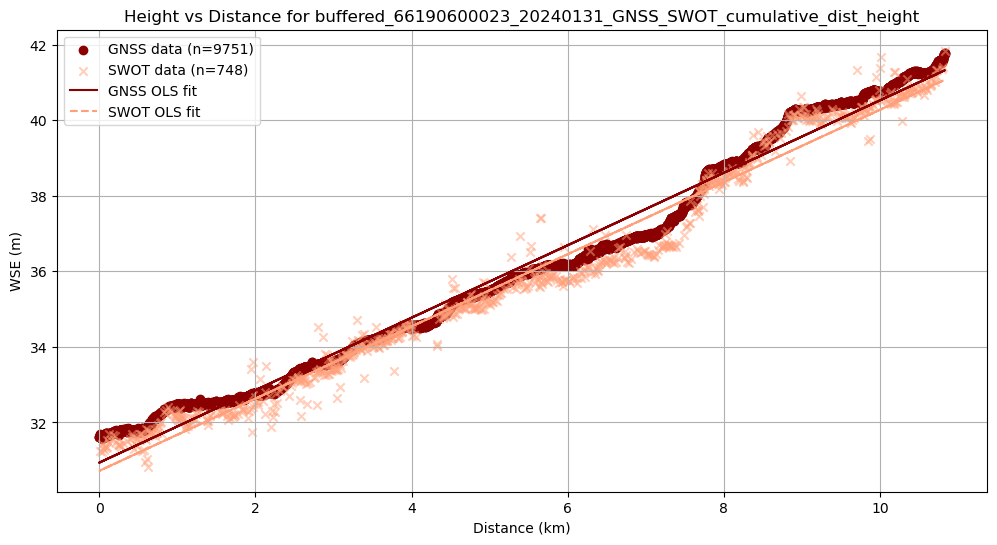

In [17]:
plt.figure(figsize=(12, 6))  # Adjust the figure size to accommodate all plots

# Loop through each key in the dictionary
for key in keys_order[5:]:
    # Load the saved CSV files
    df = pd.read_csv(f'{output_dir}/{key}_df.csv')
    df_filtered = pd.read_csv(f'{output_dir}/{key}_df_filtered.csv')

    # Apply the stable slope filter
    lower_bound = df_filtered['height_detrended'].quantile(0.03)
    upper_bound = df_filtered['height_detrended'].quantile(0.93)

    # Filter the DataFrame to keep only the rows within the 0.06 to 0.90 percentiles
    df_filtered_quantile = df_filtered[(df_filtered['height_detrended'] >= lower_bound) & 
                                       (df_filtered['height_detrended'] <= upper_bound)]

    # Determine the number of non-NA GNSS and SWOT data points
    non_na_gnss = df['Height(m)'].notna().sum()
    non_na_SWOT = df_filtered_quantile['height'].notna().sum()

    # OLS regression for GNSS data
    gnss_slope, gnss_intercept, _, _, _ = linregress(df['cumulative_distance'], df['Height(m)'])

    # OLS regression for SWOT data within quantile range
    swot_slope, swot_intercept, _, _, _ = linregress(df_filtered_quantile['nearest_GNSS_dist'], df_filtered_quantile['height'])

    # Scatter plot for cumulative_distance_GNSS vs GNSS_height
    plt.scatter(df['cumulative_distance'] / 1000, df['Height(m)'], 
                label=f'GNSS data (n={non_na_gnss})', marker='o', color=color_scheme[key])

    # Scatter plot for cumulative_distance_SWOT vs SWOT_height
    plt.scatter(df_filtered_quantile['nearest_GNSS_dist'] / 1000, df_filtered_quantile['height'], 
                label=f'SWOT data (n={non_na_SWOT})', alpha=0.5, marker='x', color=color_scheme_SWOT[key])

    # OLS line for GNSS data
    plt.plot(df['cumulative_distance'] / 1000, gnss_slope * df['cumulative_distance'] + gnss_intercept, 
             color=color_scheme[key], linestyle='-', label='GNSS OLS fit')

    # OLS line for SWOT data
    plt.plot(df_filtered_quantile['nearest_GNSS_dist'] / 1000, 
             swot_slope * df_filtered_quantile['nearest_GNSS_dist'] + swot_intercept, 
             color=color_scheme_SWOT[key], linestyle='--', label='SWOT OLS fit')

    # Adding titles and labels
    plt.title(f'Height vs Distance for {key}')
    plt.xlabel('Distance (km)')
    plt.ylabel('WSE (m)')
    plt.legend()
    plt.grid(True)

    #plt.savefig(f'figs/Red_wse.png', dpi=300, bbox_inches='tight')

    # Show plot
    plt.show()

# How well does it work?

Wow! It really seems to work! but we are not done yet. We need to apply the filter to the 3 reaches we identified as needing it, and redo the 1:1 comparison to see how the results change. 

## 1:1 comparison

We will only plot the 3 datasets idenified as needed a filter. The other 3 datasets will remain unchanged from the previous 1:1 plots.

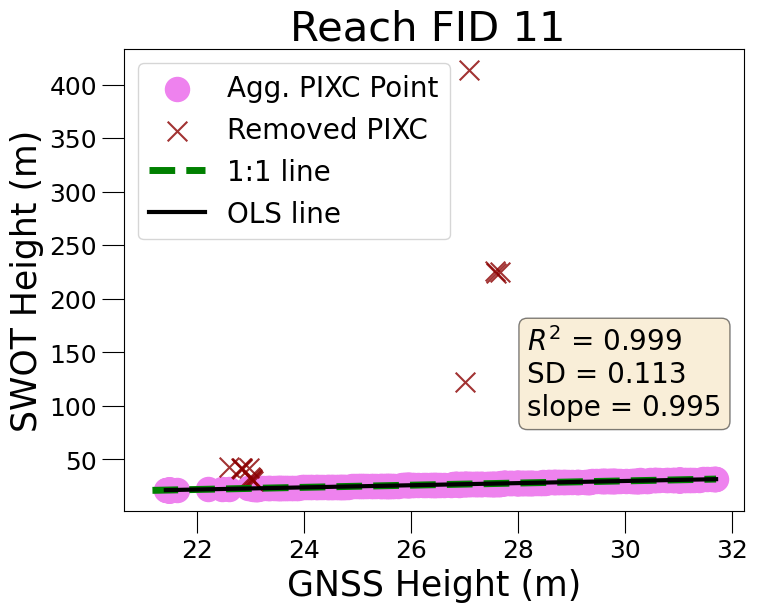

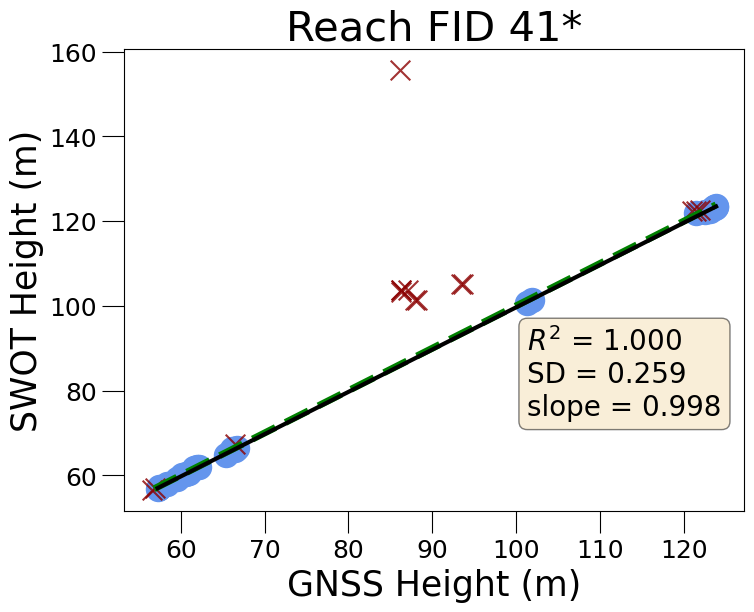

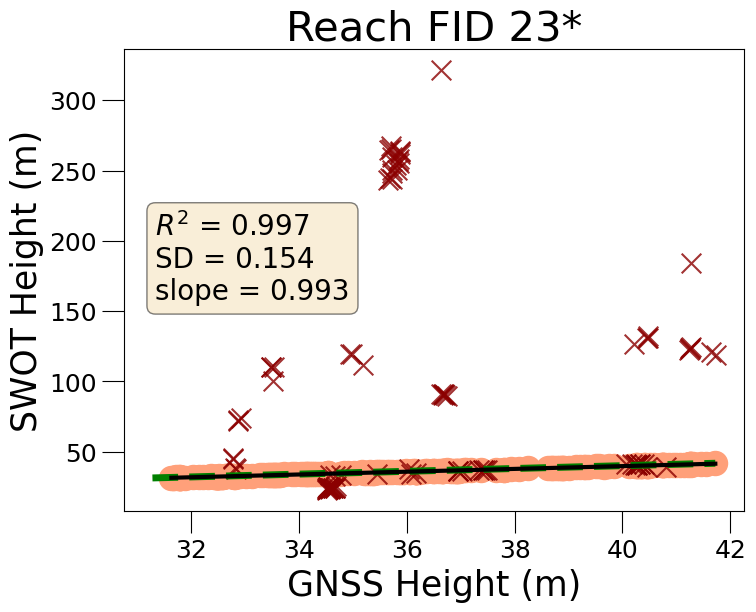

In [18]:
# Combine keys_order[0:1] and keys_order[4:]
selected_keys = keys_order[0:1] + keys_order[4:]

# Process the selected keys
for i, key in enumerate(selected_keys):
    df = pd.read_csv(f'{output_dir}/{key}_df.csv')
    df_filtered = pd.read_csv(f'{output_dir}/{key}_df_filtered.csv') 

    # Set different quantile ranges for each dataset
    if key == 'buffered_66190600041_20240131_GNSS_SWOT_cumulative_dist_height':
        lower_bound = df_filtered['height_detrended'].quantile(0.00)
        upper_bound = df_filtered['height_detrended'].quantile(0.83)
    elif key == 'buffered_66190600023_20240131_GNSS_SWOT_cumulative_dist_height':
        lower_bound = df_filtered['height_detrended'].quantile(0.04)
        upper_bound = df_filtered['height_detrended'].quantile(0.93)
    elif key == 'buffered_66190600011_GNSS_SWOT_cumulative_dist_height':
        lower_bound = df_filtered['height_detrended'].quantile(0.00)
        upper_bound = df_filtered['height_detrended'].quantile(0.99)

    # Create masks for in-bound and out-of-bound points
    mask_in_bounds = (df_filtered['height_detrended'] >= lower_bound) & (df_filtered['height_detrended'] <= upper_bound)

    df_in_bounds = df_filtered[mask_in_bounds].copy()
    df_out_of_bounds = df_filtered[~mask_in_bounds].copy()  # Points outside the bounds

    # Bin and average GNSS data
    bins_gnss = np.arange(0, df['cumulative_distance'].max() + 50, 50)
    bins_swot = np.arange(0, df_in_bounds['cumulative_distance'].max() + 50, 50)
    
    df['binned_distance_GNSS'] = pd.cut(df['cumulative_distance'], bins=bins_gnss)
    df_binned_gnss = df.groupby('binned_distance_GNSS', as_index=False, observed=True).agg({
        'cumulative_distance': 'median',
        'Height(m)': 'median'
    }).dropna()
    df_binned_gnss['bin'] = df_binned_gnss['binned_distance_GNSS'].apply(lambda interval: float(interval.left))
    
    # Bin and average SWOT data based on GNSS distance downstream
    df_in_bounds['binned_distance_GNSS'] = pd.cut(df_in_bounds['cumulative_distance'], bins=bins_swot)
    df_binned_swot = df_in_bounds.groupby('binned_distance_GNSS', observed=True, as_index=False).agg({
        'cumulative_distance': 'median',
        'height': 'median'
    }).dropna()
    df_binned_swot['bin'] = df_binned_swot['binned_distance_GNSS'].apply(lambda interval: float(interval.left))

    # Extract unique bin values from each DataFrame
    bins_swot_set = set(df_binned_swot['bin'])
    bins_gnss_set = set(df_binned_gnss['bin'])

    # Compute the intersection of the two sets
    common_bins = bins_swot_set.intersection(bins_gnss_set)

    # Filter both DataFrames to include only the common bins
    df_binned_swot_filtered = df_binned_swot[df_binned_swot['bin'].isin(common_bins)]
    df_binned_gnss_filtered = df_binned_gnss[df_binned_gnss['bin'].isin(common_bins)]

    # Merge the two DataFrames on 'bin'
    merged_df = pd.merge(df_binned_gnss_filtered, df_binned_swot_filtered, on='bin', suffixes=('_gnss', '_swot'))

    # Extract heights for in-bounds points
    x = merged_df['Height(m)']   # GNSS heights (x-axis)
    y = merged_df['height']      # SWOT heights (y-axis)

    # Ensure out-of-bounds points are plotted in the same way (GNSS vs. SWOT)
    df_out_of_bounds_merged = pd.merge(df_out_of_bounds, df, on='cumulative_distance', suffixes=('_out', '_gnss'))

    x_out = df_out_of_bounds_merged['Height(m)_gnss']  # GNSS heights for out-of-bounds points
    y_out = df_out_of_bounds_merged['height_out']  # SWOT heights for out-of-bounds points

    # Compute the best-fit line and statistics
    slope, intercept = np.polyfit(x, y, 1)
    line_x = np.linspace(x.min(), x.max(), 100)
    line_y = slope * line_x + intercept
    y_at_xmin = slope * x.min() + intercept
    y_bias = y_at_xmin - x.min()

    # Calculate R² (coefficient of determination)
    correlation_matrix = np.corrcoef(x, y)
    correlation_xy = correlation_matrix[0, 1]
    r_squared = correlation_xy ** 2

    # Calculate the standard deviation (SD) of the residuals
    predicted_y = slope * x + intercept
    residuals = y - predicted_y
    sd = np.std(residuals)

    # Plot the data
    plt.figure(figsize=(8, 6))

    # Scatter plot for in-bound points with the original color scheme
    plt.scatter(x, y, marker='o', color=color_scheme_SWOT[key], s=300, label='Agg. PIXC Point')
    
    # Scatter plot for out-of-bound points in grey (now correctly using GNSS vs SWOT)
    plt.scatter(x_out, y_out, marker='x', color='darkred', s=200, alpha=0.8, label='Removed PIXC')

    # Add the 1:1 line (slope 1 through the origin)
    min_val = min(x.min(), y.min())
    max_val = max(x.max(), y.max())
    identity_line = np.linspace(min_val, max_val, 100)
    plt.plot(identity_line, identity_line, color='green', linewidth=5, linestyle='--', label='1:1 line')

    # Plot the best-fit line
    plt.plot(line_x, line_y, color='black', linewidth=3, label=f'OLS line')

    # Label axes and title
    plt.xlabel('GNSS Height (m)', fontsize=25)
    plt.ylabel('SWOT Height (m)', fontsize=25)

    # Define custom text positions for each of the three plots
    if i < 2:
        text_x, text_y = 0.65, 0.40  # First two plots
    else:
        text_x, text_y = 0.05, 0.65  # Last plot
    
    # Annotate the plot with R², SD, and slope values
    plt.text(text_x, text_y, f'$R^2$ = {r_squared:.3f}\nSD = {sd:.3f}\nslope = {slope:.3f}',
             transform=plt.gca().transAxes,
             verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5), fontsize=20)

    if i == 0:  # Only add legend on the first plot
        plt.legend(fontsize=20)

    # Extract numerical value from key
    key_numeric = re.search(r'_(\d+)_', str(key))
    key_label = key_numeric.group(1) if key_numeric else 'Unknown'

    # Set title
    plt.title(f'Reach FID {key_labels[key][-3:]}', fontsize=30)
    plt.tick_params(axis='both', which='major', labelsize=18, size=16)

        # Define a filename based on the key
    filename = f"publication_figs_2/1:1_filtered_{key_labels[key][-3:]}.jpg"

    # Save the figure as a high-resolution .jpg
    #plt.savefig(filename, dpi=300, bbox_inches='tight', format='jpg')

    # Show the plot
    plt.show()


## OLS Slope comparison

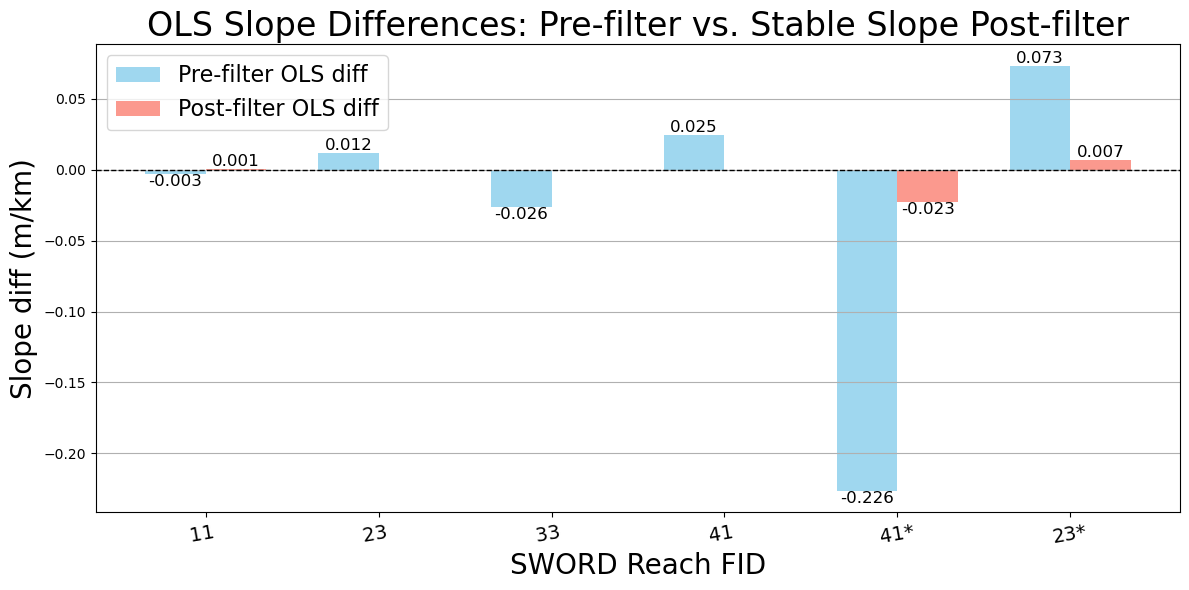

In [20]:
# The special keys for which filtered data exist:
special_keys = keys_order[0:1] + keys_order[4:]
# We'll compute the post-filter OLS diff for these keys and store them in a dictionary.
postfilter_diffs = {}

for key in special_keys:
    # Read in the datasets (these are only available for the filtered sections)
    df = pd.read_csv(f'{output_dir}/{key}_df.csv')
    df_filtered = pd.read_csv(f'{output_dir}/{key}_df_filtered.csv')
    
    # Set quantile ranges differently for these keys
    if key == 'buffered_66190600041_20240131_GNSS_SWOT_cumulative_dist_height':
        lower_bound = df_filtered['height_detrended'].quantile(0.00)
        upper_bound = df_filtered['height_detrended'].quantile(0.83)
    elif key == 'buffered_66190600023_20240131_GNSS_SWOT_cumulative_dist_height':
        lower_bound = df_filtered['height_detrended'].quantile(0.04)
        upper_bound = df_filtered['height_detrended'].quantile(0.93)
    elif key == 'buffered_66190600011_GNSS_SWOT_cumulative_dist_height':
        lower_bound = df_filtered['height_detrended'].quantile(0.00)
        upper_bound = df_filtered['height_detrended'].quantile(0.99)
    
    # Apply the quantile filter
    df_filtered_quant = df_filtered[(df_filtered['height_detrended'] >= lower_bound) &
                                    (df_filtered['height_detrended'] <= upper_bound)].copy()
    
    # Define bins (same for GNSS in both cases)
    bins_gnss = np.arange(0, df['cumulative_distance'].max() + 2, 2)
    bins_swot = np.arange(0, df_filtered_quant['nearest_GNSS_dist'].max() + 50, 50)
    
    # Bin and aggregate GNSS data
    df['binned_distance_GNSS'] = pd.cut(df['cumulative_distance'], bins=bins_gnss)
    df_binned_gnss = df.groupby('binned_distance_GNSS', observed=True)\
                       .agg({'cumulative_distance': 'median', 'Height(m)': 'median'})\
                       .dropna()
    
    # Bin and aggregate the post-filter SWOT data
    df_filtered_quant.loc[:, 'binned_distance_SWOT'] = pd.cut(df_filtered_quant['nearest_GNSS_dist'], bins=bins_swot)
    df_binned_swot_post = df_filtered_quant.groupby('binned_distance_SWOT', observed=True)\
                                           .agg({'nearest_GNSS_dist': 'median', 'height': 'median'})\
                                           .dropna()
    
    # Compute OLS regression slopes
    gnss_slope, _, _, _, _ = linregress(df_binned_gnss['cumulative_distance'], df_binned_gnss['Height(m)'])
    if len(df_binned_swot_post) > 1:
        swot_slope_post, _, _, _, _ = linregress(df_binned_swot_post['nearest_GNSS_dist'],
                                                 df_binned_swot_post['height'])
    else:
        swot_slope_post = np.nan
    # Calculate post-filter difference (in cm/km)
    post_diff = gnss_slope * 1000 - swot_slope_post * 1000
    postfilter_diffs[key] = post_diff

# Now prepare for plotting.
# Pre-filter differences are already stored in ols_slopes for all keys.
indices = np.arange(len(keys_order))
bar_width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))

# Plot pre-filter differences (for all keys)
bars_pre = ax.bar(indices - bar_width/2, ols_slopes, bar_width,
                  label='Pre-filter OLS diff', color='skyblue', alpha=0.8)

# Build a list of post-filter differences corresponding to keys_order;
# for keys without a post-filter result, insert np.nan.
post_diffs_plot = [postfilter_diffs[key] if key in postfilter_diffs else np.nan for key in keys_order]

# Identify indices for keys that have a valid post-filter result
special_indices = [i for i, key in enumerate(keys_order) if key in postfilter_diffs]
special_post_values = [postfilter_diffs[key] for key in keys_order if key in postfilter_diffs]

# Plot the post-filter bars only for the special keys
bars_post = ax.bar(np.array(indices)[special_indices] + bar_width/2, special_post_values, bar_width,
                   label='Post-filter OLS diff', color='salmon', alpha=0.8)

# Draw a horizontal reference line at y=0
ax.axhline(0, color='black', linewidth=1, linestyle='--')

# Set title and axis labels
ax.set_title('OLS Slope Differences: Pre-filter vs. Stable Slope Post-filter', fontsize=24)
ax.set_ylabel('Slope diff (m/km)', fontsize=20)
ax.set_xlabel('SWORD Reach FID', fontsize=20)
ax.set_xticks(indices)
ax.set_xticklabels([key_labels[key][-3:] for key in keys_order], fontsize=14, rotation=10)

# Annotate pre-filter bars with their values
for bar, slope in zip(bars_pre, ols_slopes):
    height = bar.get_height()
    va = 'bottom' if height >= 0 else 'top'
    ax.text(bar.get_x() + bar.get_width()/2, height, f'{slope:.3f}', ha='center', va=va, fontsize=12)

# Annotate post-filter bars (only special keys)
for idx, bar in zip(special_indices, bars_post):
    height = bar.get_height()
    va = 'bottom' if height >= 0 else 'top'
    ax.text(bar.get_x() + bar.get_width()/2, height, f'{height:.3f}', ha='center', va=va, fontsize=12)

ax.legend(fontsize=16)
ax.grid(True, axis='y')
plt.tight_layout()
plt.show()


## Quick Discussion

The results are much improved. However, note that we filtered the raw, unbinned data, while the 1:1 comparison uses binned data. The Xs represent the unbinned data removed from the final binning used for summary statistics. Each SWOT point has a corresponding GNSS point (with height), establishing a 1:1 relationship between SWOT WSE and GNSS WSE. This allows the unbinned Xs to be plotted alongside the binned data, highlighting the removed points. Additionally, each unbinned X retains all information from a SWOT PIXC point—such as latitude, longitude, and quality indicators—which may be useful for further analyses like exploring how topography, geolocation quality, or coherence might affect accuracy.

The OLS comparison also shows us that the difference between OLS slope between GNSS and SWOT improves drastically after the stable slope filter is applied to the 3 reaches identified as needing it (reaches 11, 41*, and 23*), especially in reaches 41* and 23*. While the results of reach 11 did improve, the prefilter difference was already very small. Also note that reaches 23, 33, and 41 did not have a post filter difference because the filter was not applied to them.

# Disclaimer

The code in this analysis is indended to highlight statistical concepts, and is not written with efficiency in mind. 